In [13]:
from sys import version

print(version)
print("HEY")

3.8.2 (default, Mar 11 2020, 00:28:52) 
[Clang 11.0.0 (clang-1100.0.33.17)]
HEY


In [14]:
from app import AppContext, Word as WordModel
from core import LoadConfig
import numpy as np

from time import time

from time_series import TimeSeries

In [15]:
ctx = AppContext(LoadConfig("configs/main.yaml"))


async def download_word(alpha, period_s=60 * 60 * 24 * 30 * 6):
    word_p = []
    start_time = time() - period_s
    async for word in ctx.db.find(WordModel(word=alpha)):
        if word.date >= start_time:
            word_p.append(word.date)
    word_ts = np.array(word_p)
    return TimeSeries(alpha, word_ts)


async def _download(word: str, period_s: int):
    word_p = []

    start_time = time() - period_s
    async for word in ctx.db.find(WordModel(word=word)):
        if word.date >= start_time:
            word_p.append((word.date, word.from_id, word.post_id))

    return word_p

async def download_pair(alpha, beta, period_s=60 * 60 * 24 * 30 * 6):
    word_alpha_p = await _download(alpha, period_s)
    word_beta_p = await _download(beta, period_s)
    common = set(word_alpha_p).intersection(word_beta_p)

    DATE_INDEX = 0
    word_ts = np.array(tuple(word_info[DATE_INDEX] for word_info in common))
    return TimeSeries(f"{alpha}&{beta}", word_ts)



[2020-04-18 15:52:03.640800] [  INFO   ] /53103/ LoadConfig core/config/__init__.py:13 LoadConfig: Load config source=configs/main.yaml


In [16]:
async def word_counter():
    async for item in ctx.db.db.Word.aggregate([
       { "$match": {}},
       { "$group": {
           "_id": "$word",
           "count": { "$sum": 1 }
       }},
       {'$sort': {'count': -1}}
    ]):
        yield item['_id'], item['count']

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting

def plot(ax, word: TimeSeries, name: str):
    from datetime import datetime

    if word.ts[0] < time() / 2:
        t = word.ts
    else:
        t = [datetime.fromtimestamp(ts) for ts in word.ts]
    s = word.vs
    ax.plot(t, s, label=name)

def get_ax(title):
    fig, ax = plt.subplots()

    fig.set_figwidth(15)
    fig.set_figheight(15)
    
    ax.set(xlabel='Date', ylabel='Posts/period',
           title=title)
    ax.grid()
    
    return ax
    

In [18]:
words_pairs = {}
words = {}

<TimeSeries of `новый` [2019-10-21T09:37:10Z - 2020-04-16T09:50:56Z] 3390 items, ∑=4580.00>
<TimeSeries of `год` [2019-10-21T09:11:12Z - 2020-04-16T04:57:00Z] 4721 items, ∑=7738.00>
<TimeSeries of `мир` [2019-10-21T12:58:01Z - 2020-04-15T16:22:16Z] 1728 items, ∑=2529.00>


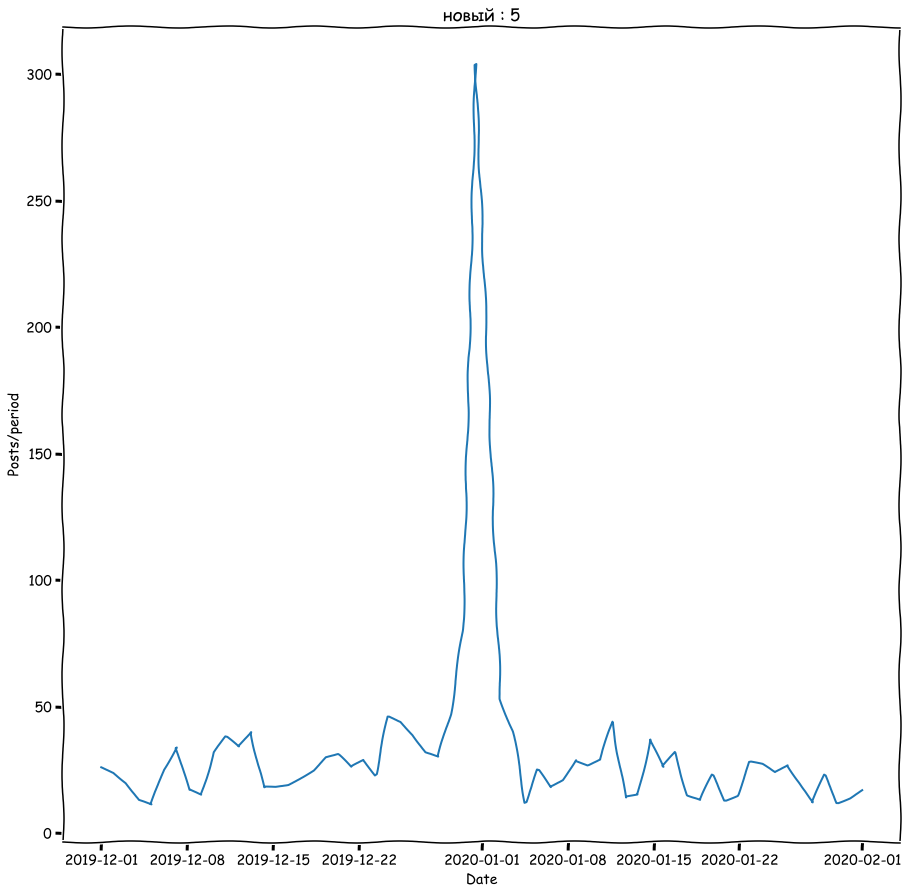

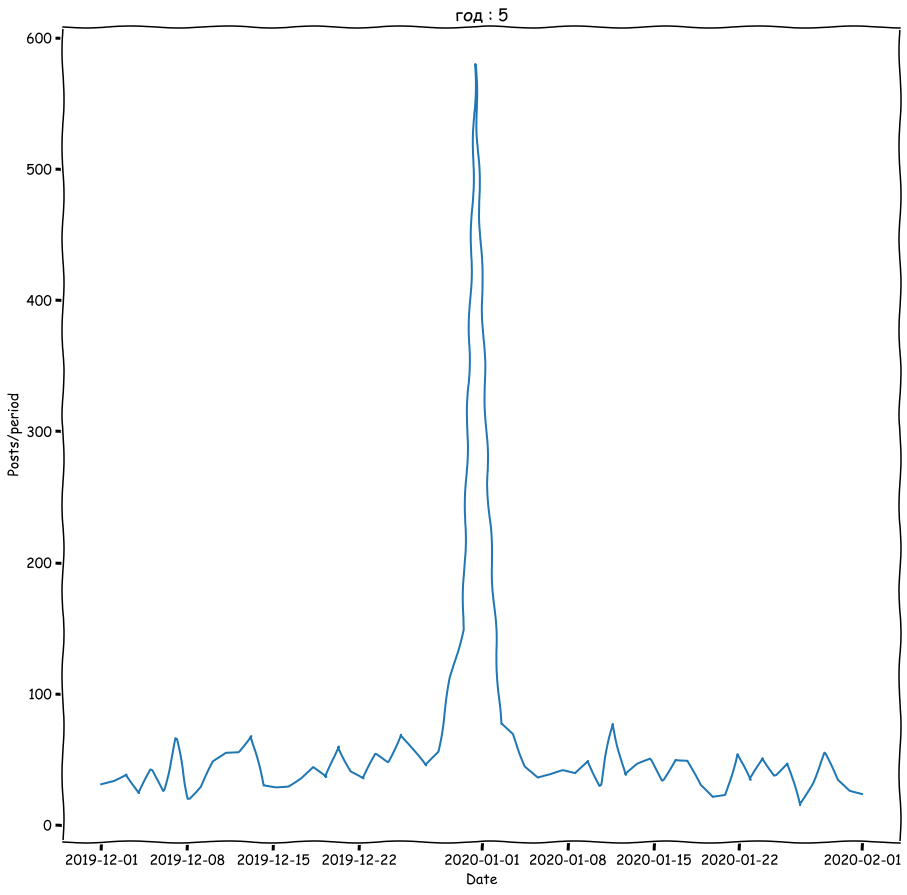

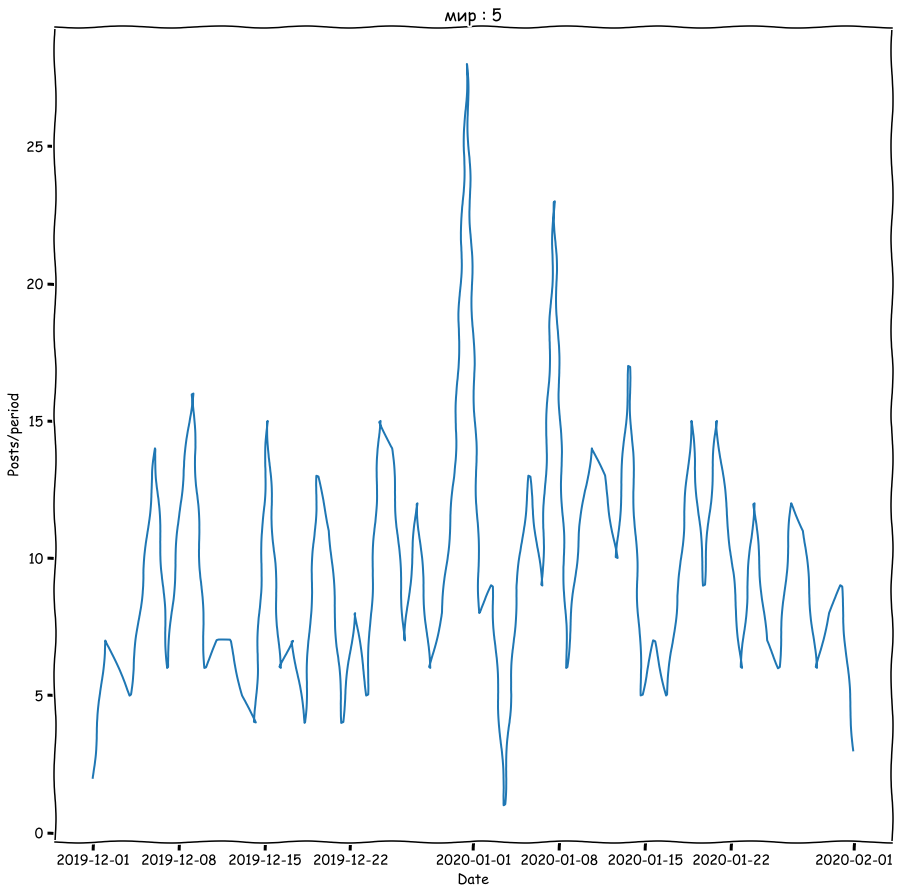

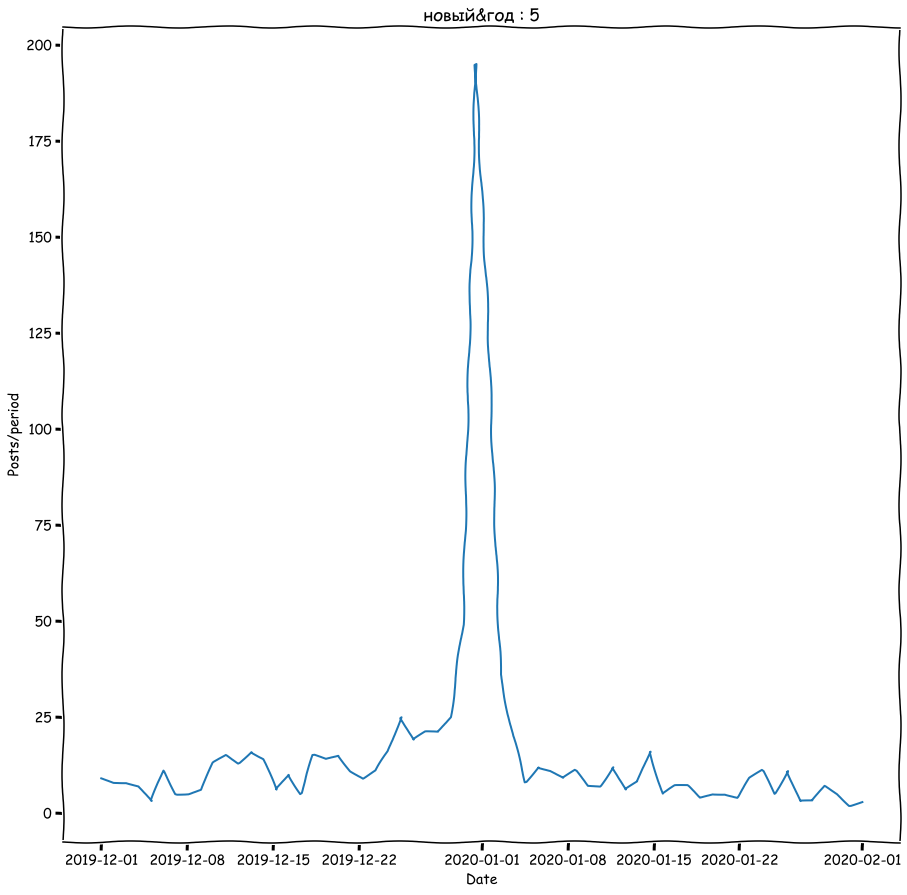

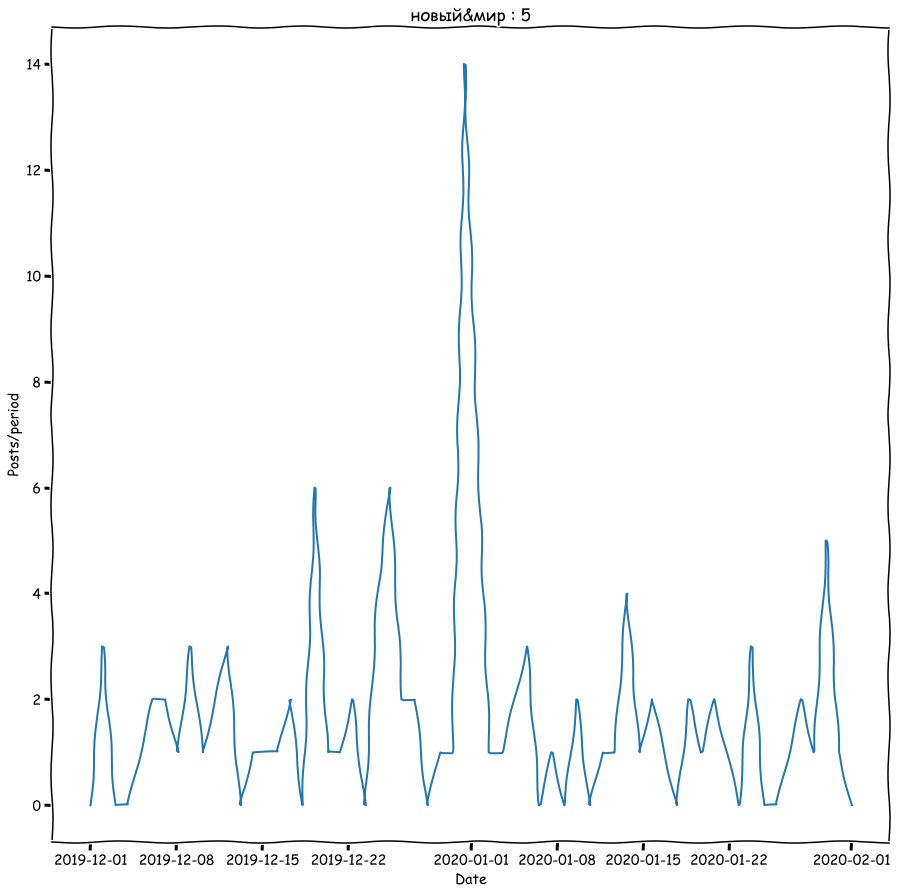

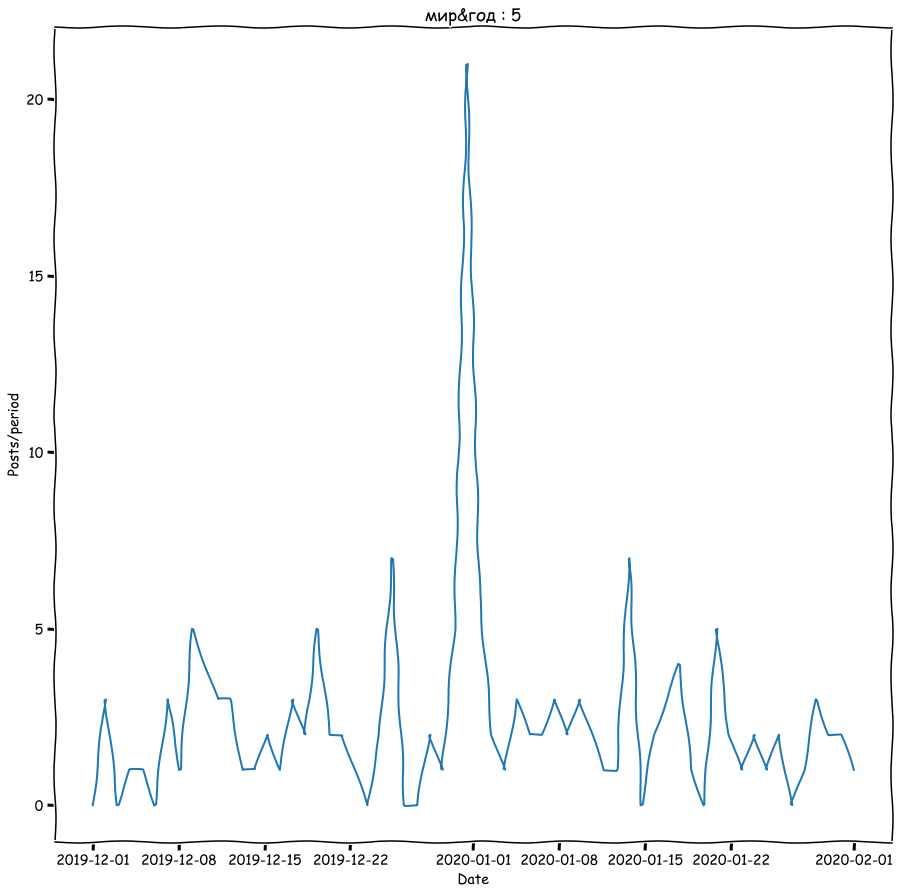

In [12]:
import datetime
from_ = datetime.datetime(2019, 12, 1)
to_ = datetime.datetime(2020, 2, 1)

grid_period = datetime.timedelta(days=1)

from core import Log
log = Log('draw')
for ks in "новый", "год", "мир", ["новый", "год"], ["новый", "мир"], ["мир", "год"]:
    if isinstance(ks, list):
        assert len(ks) == 2
        key = tuple(ks)
        if key not in words_pairs:
            word = words_pairs[key] = await download_pair(ks[0], ks[1])

        word = words_pairs[key]

    else:
        if not isinstance(ks, tuple):
            ks = (ks, )

        for k in ks:
            if k not in words:
                words[k] = await download_word(k)

        word = words[ks[0]]
        for k in ks[1:]:
            word += words[k]
        
        print(word)
    
    for periods in (5, ):
        try:
            with plt.xkcd():
                name = word.name
                ax = get_ax(f"{name} : {periods}")
                
                plot(ax, word[from_:to_:grid_period], name=name)
                # plt.savefig(f'data/pictures/_new/{word}_{periods}.png')

        except Exception as e:
            log.exception(word, periods, e)

plt.show()

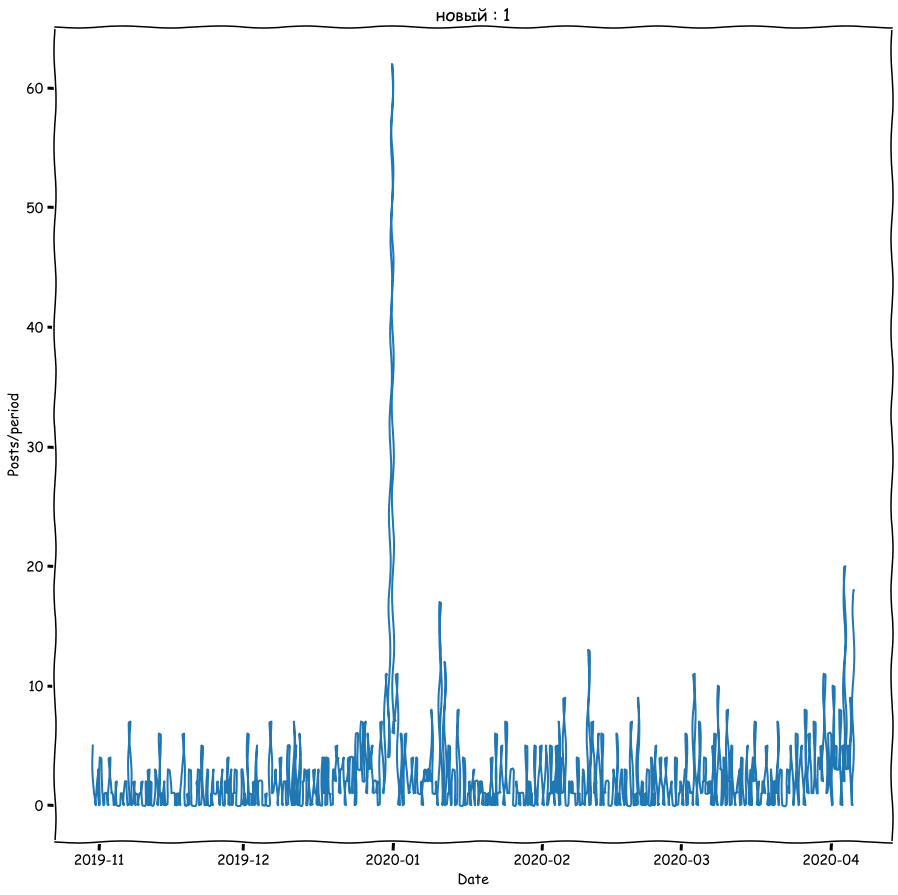

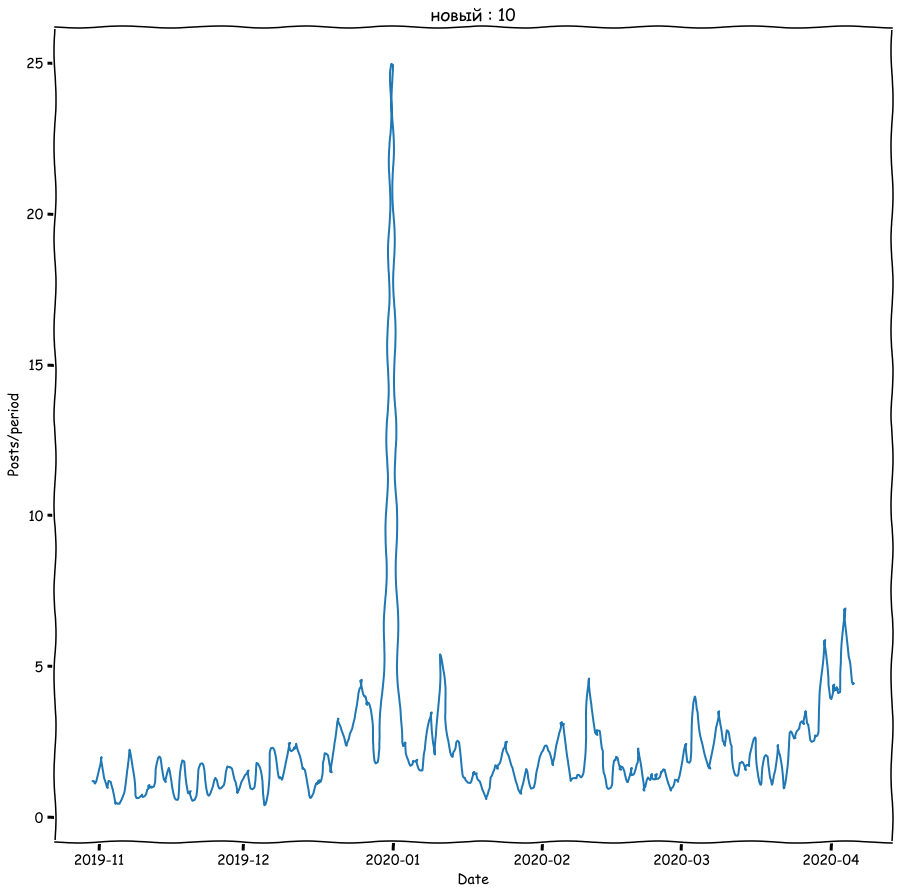

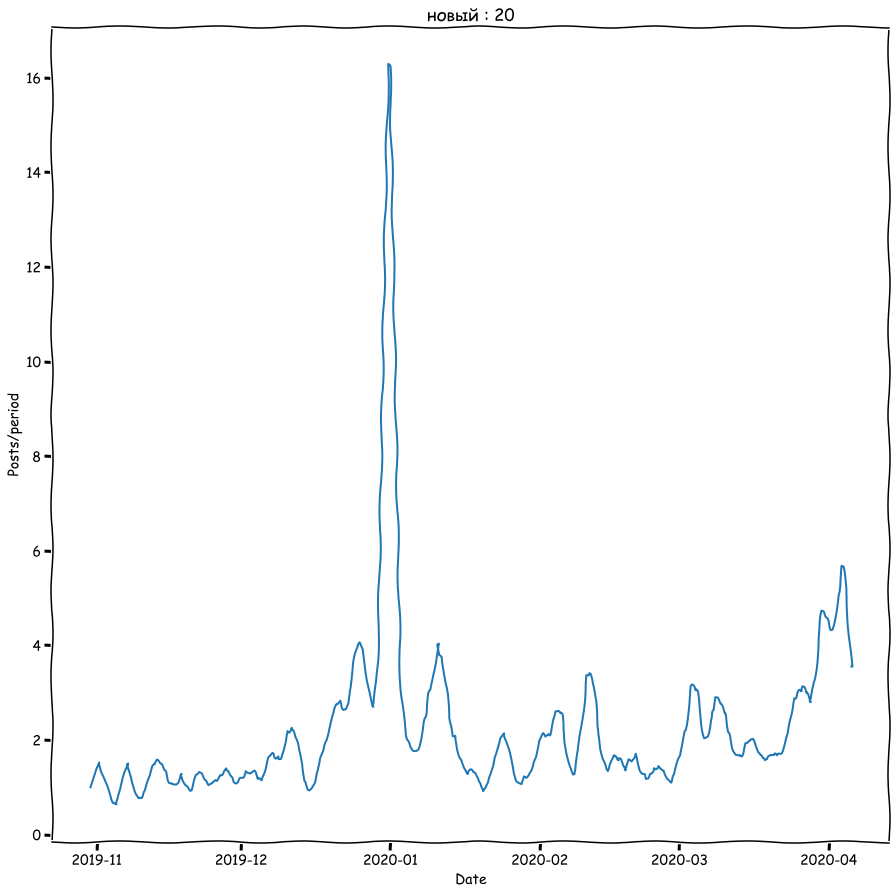

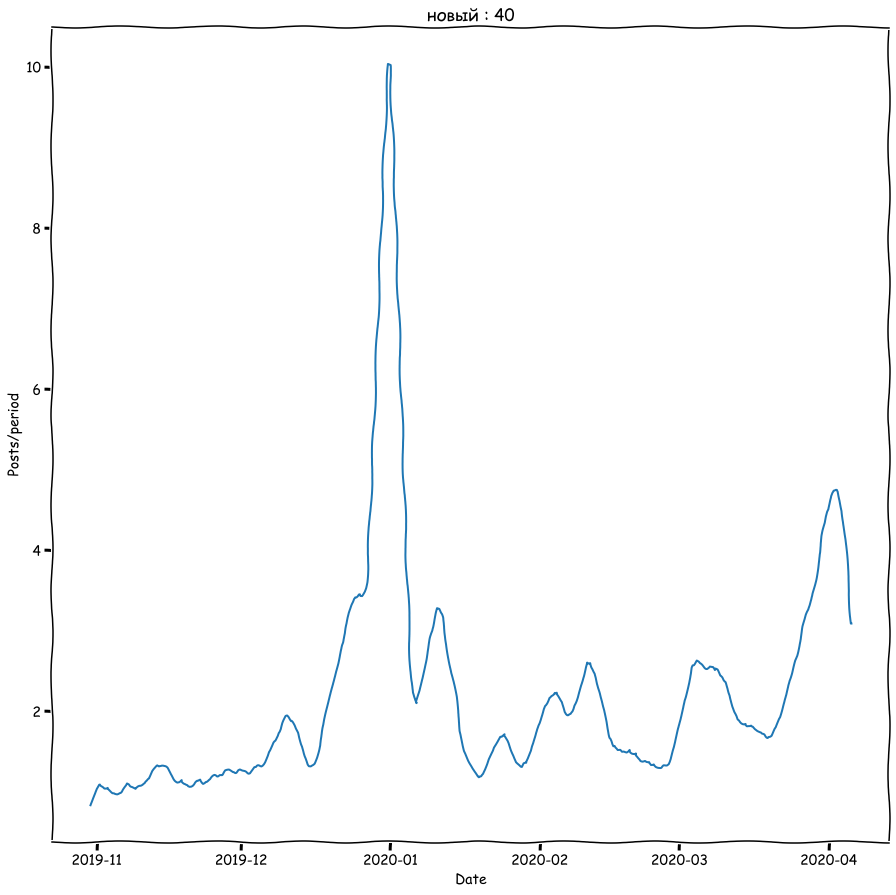

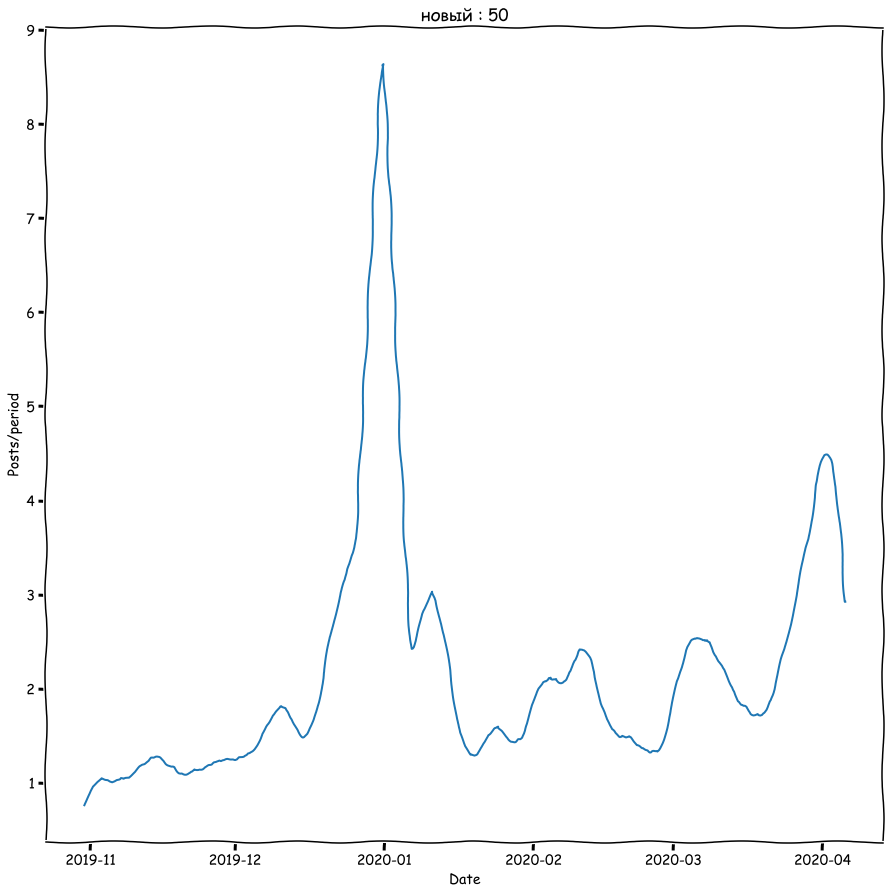

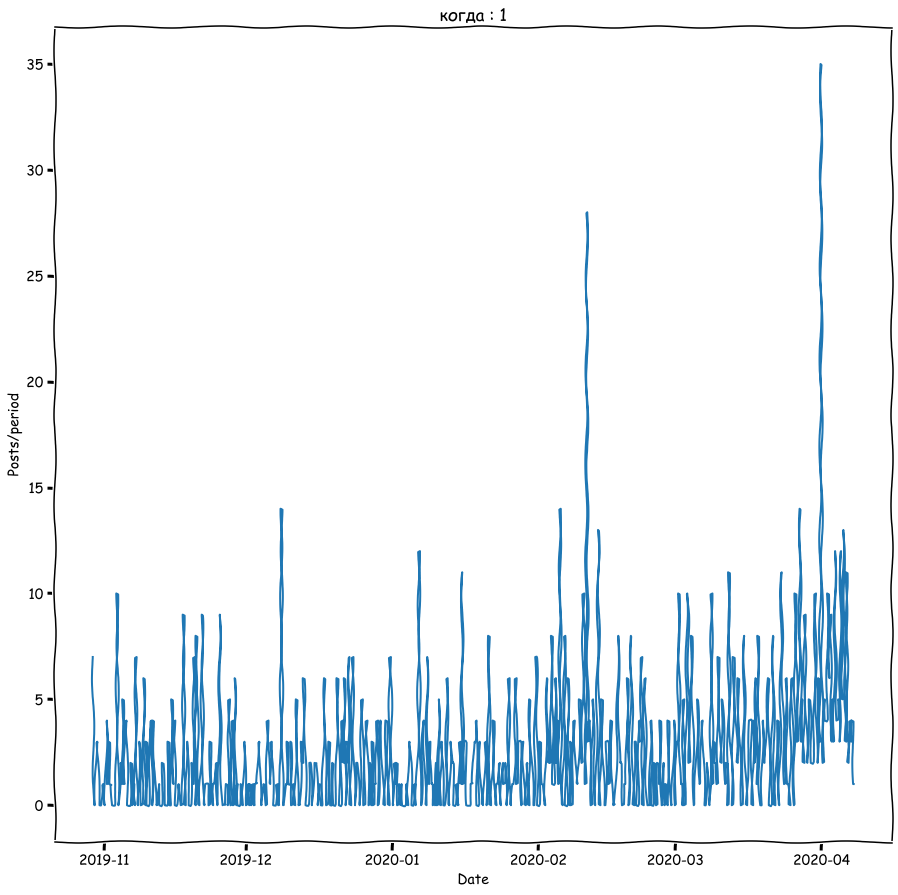

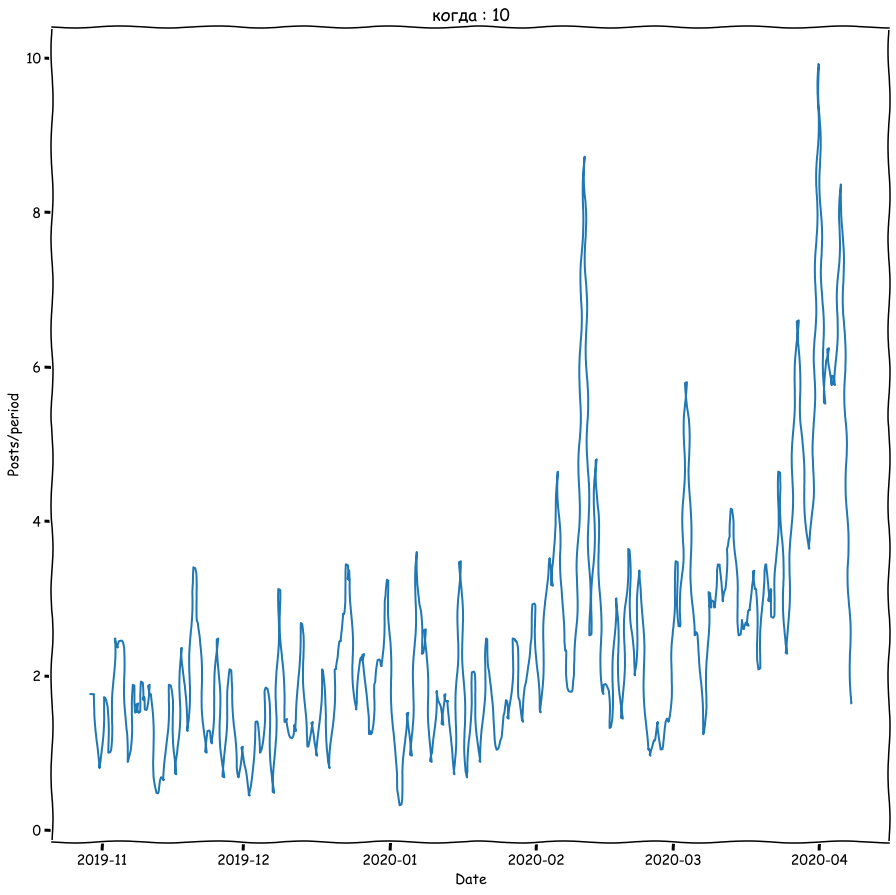

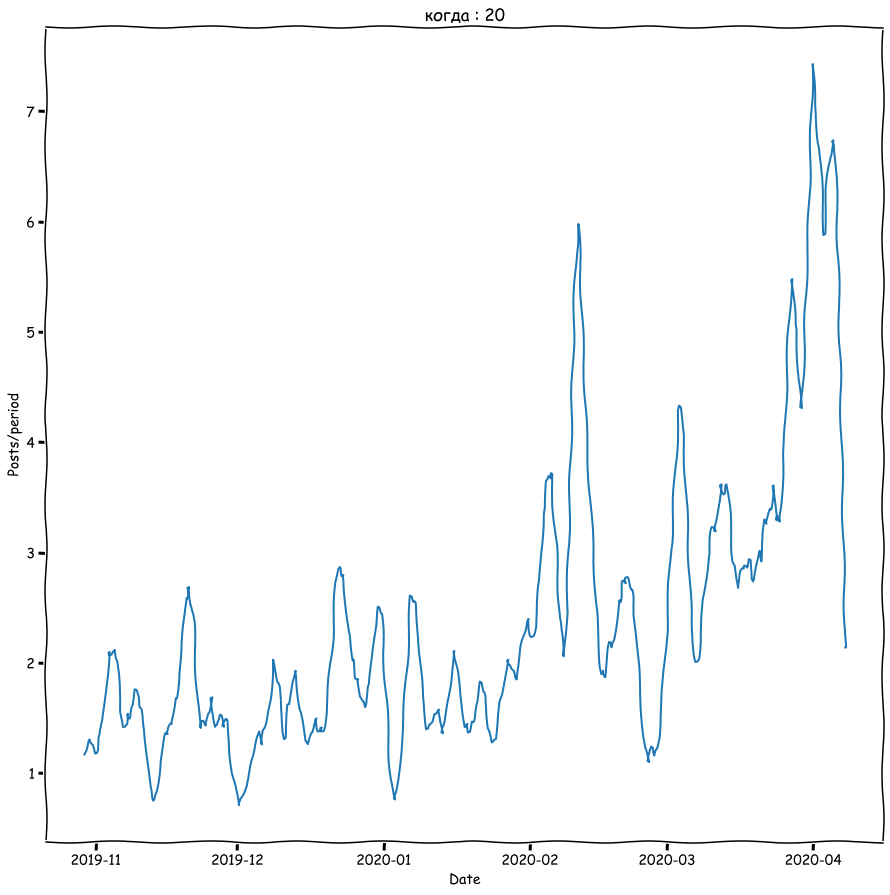

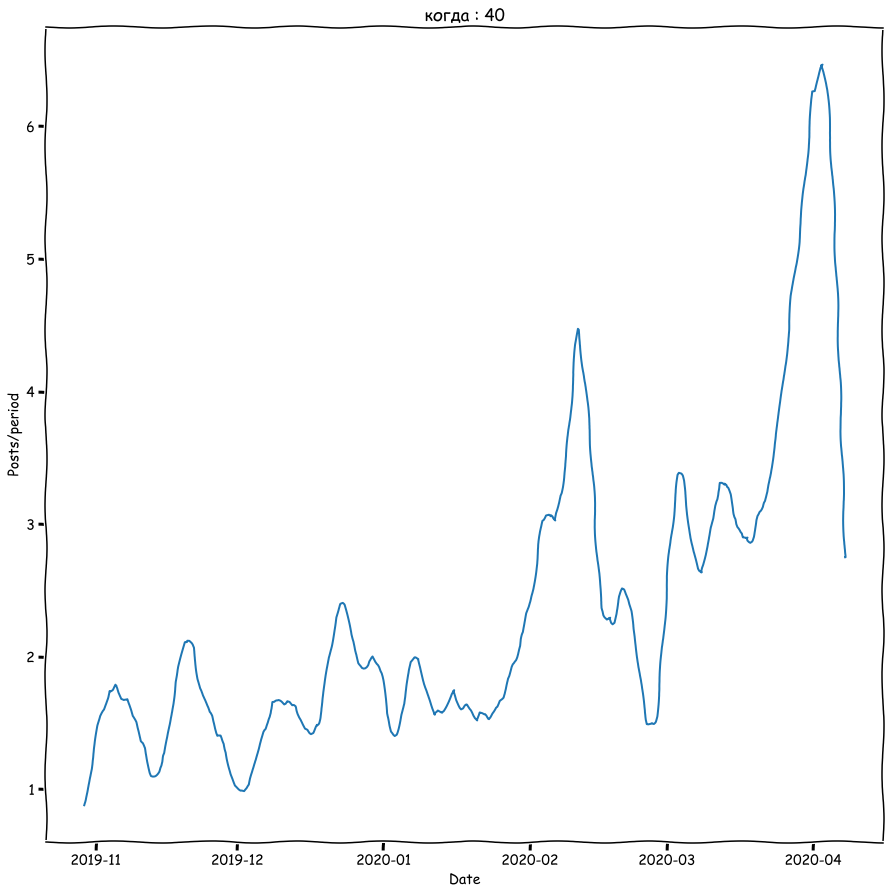

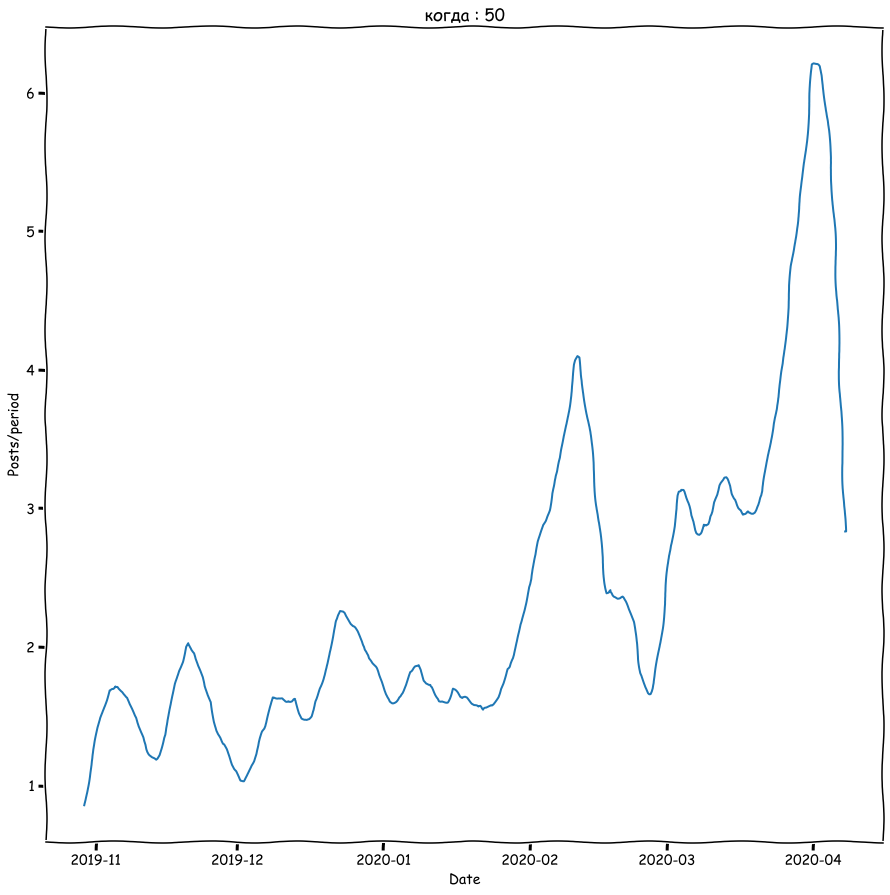

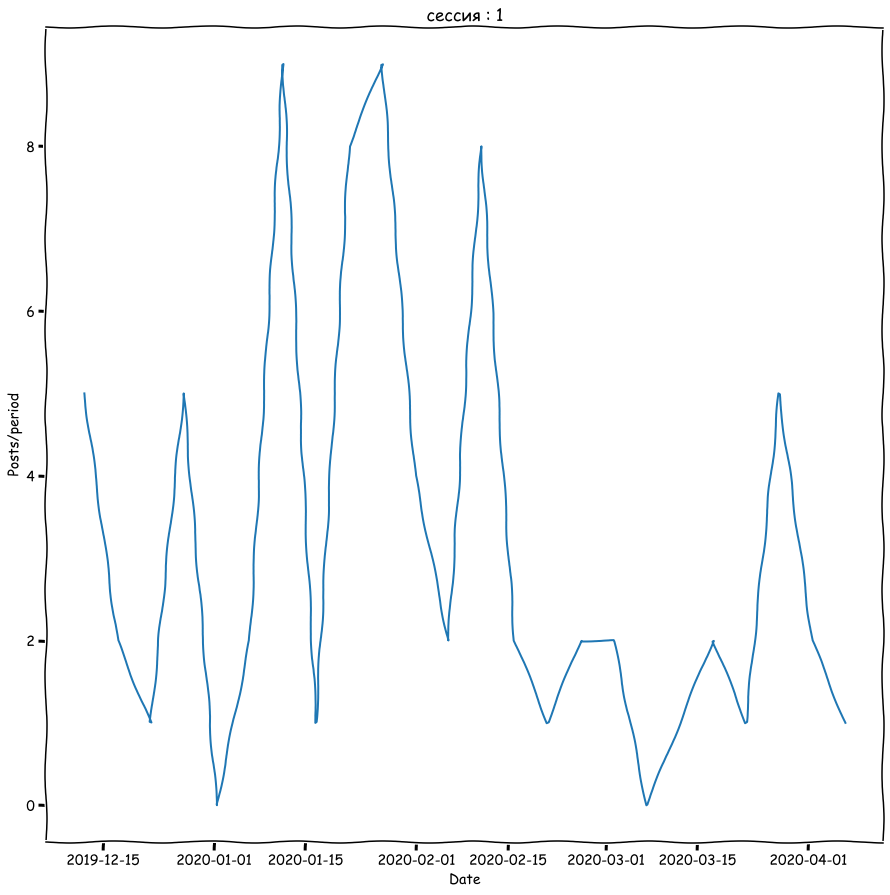

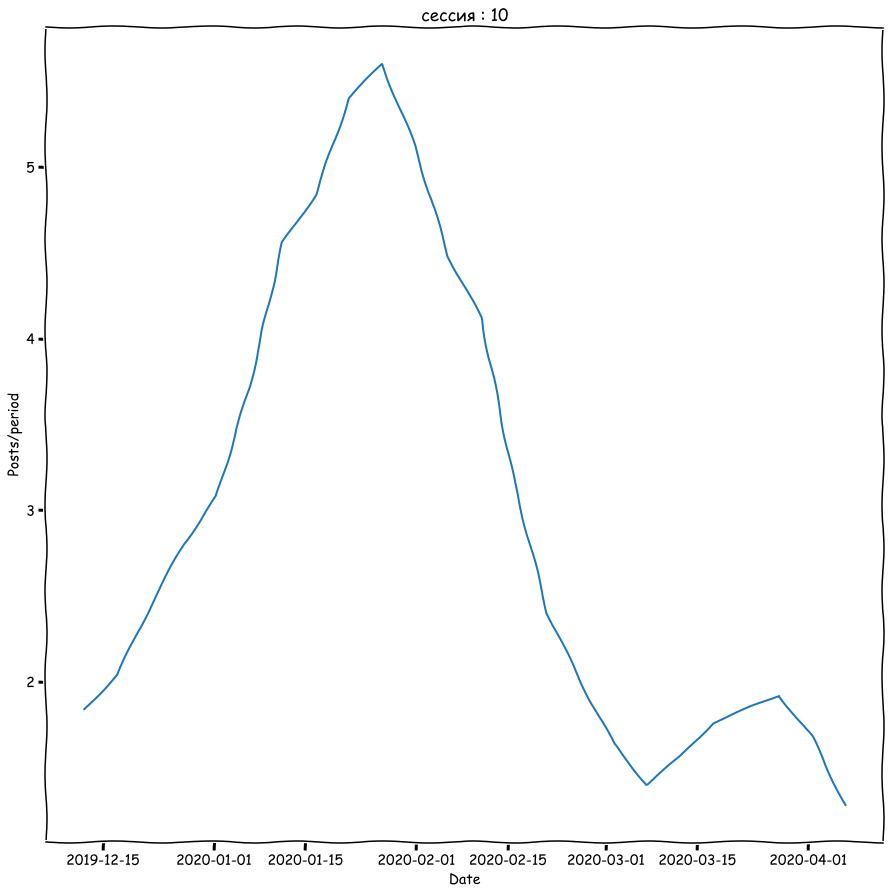

(24, 39)
(24, 49)


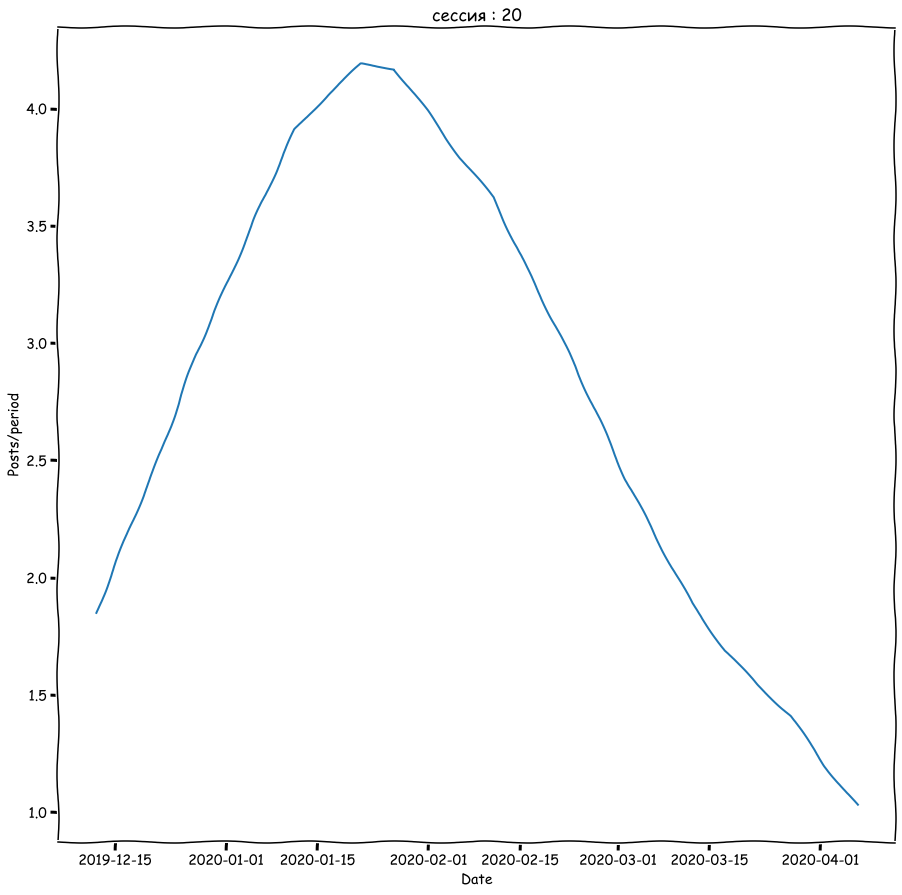

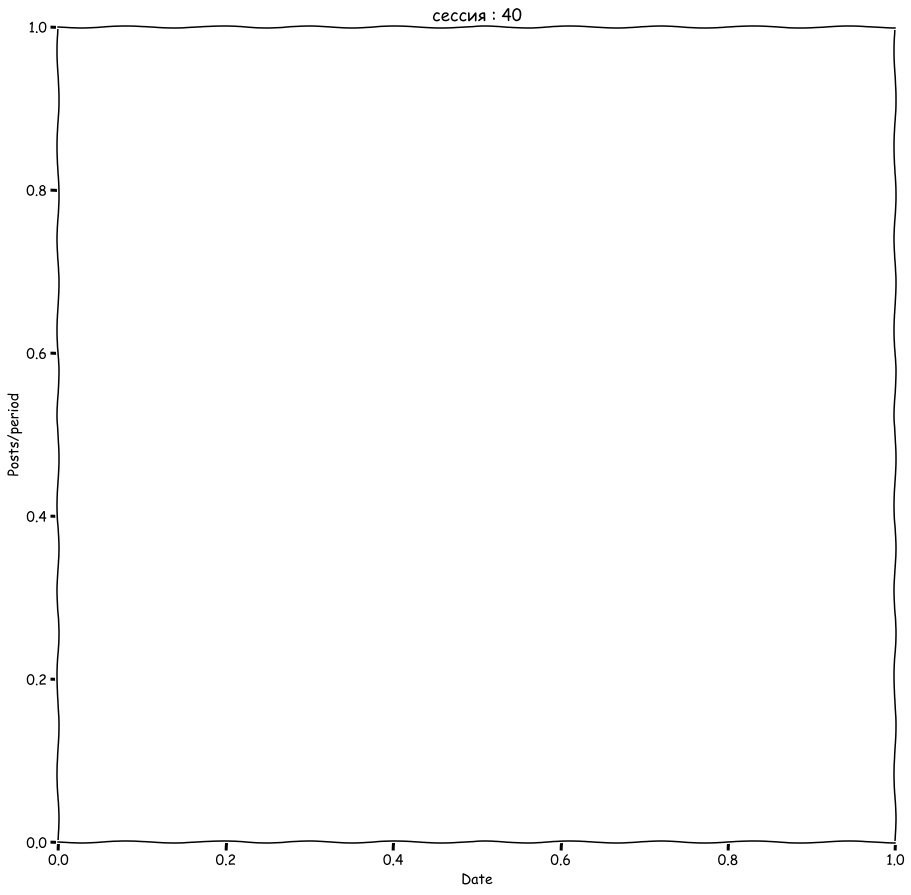

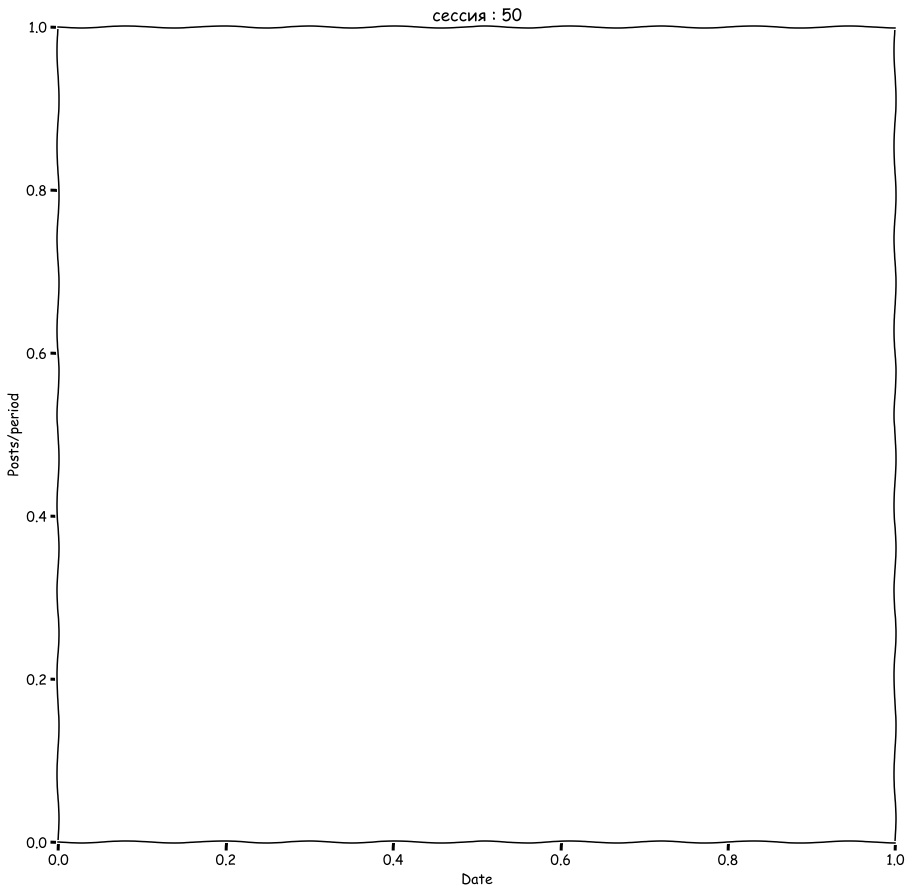

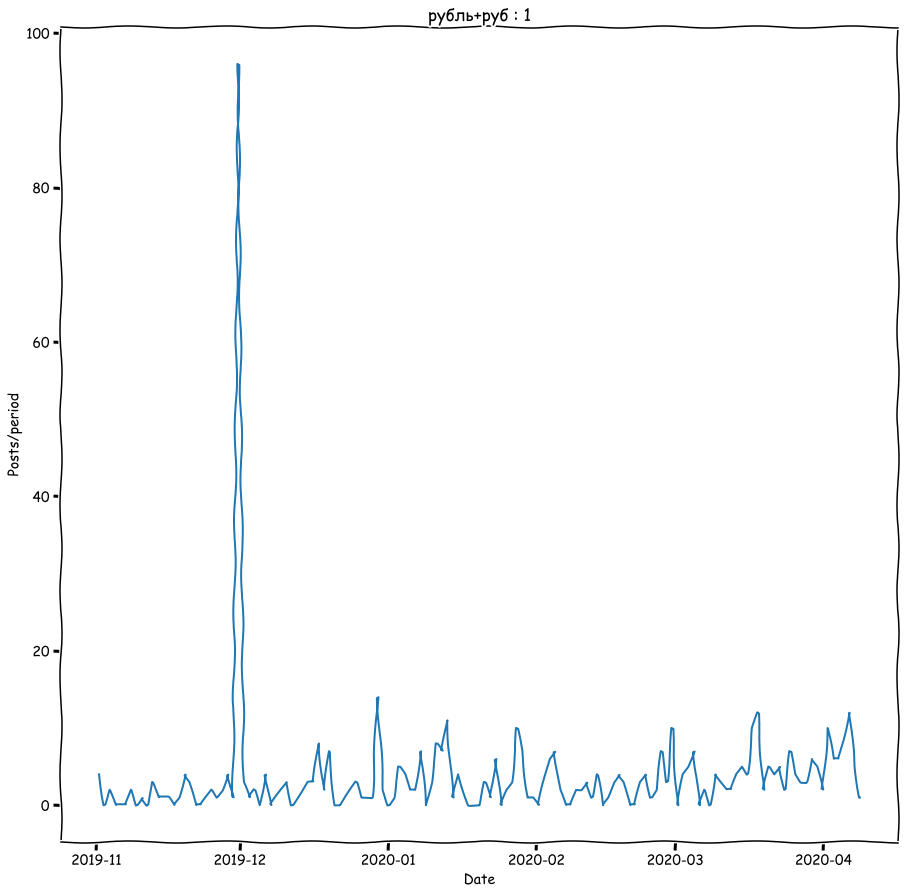

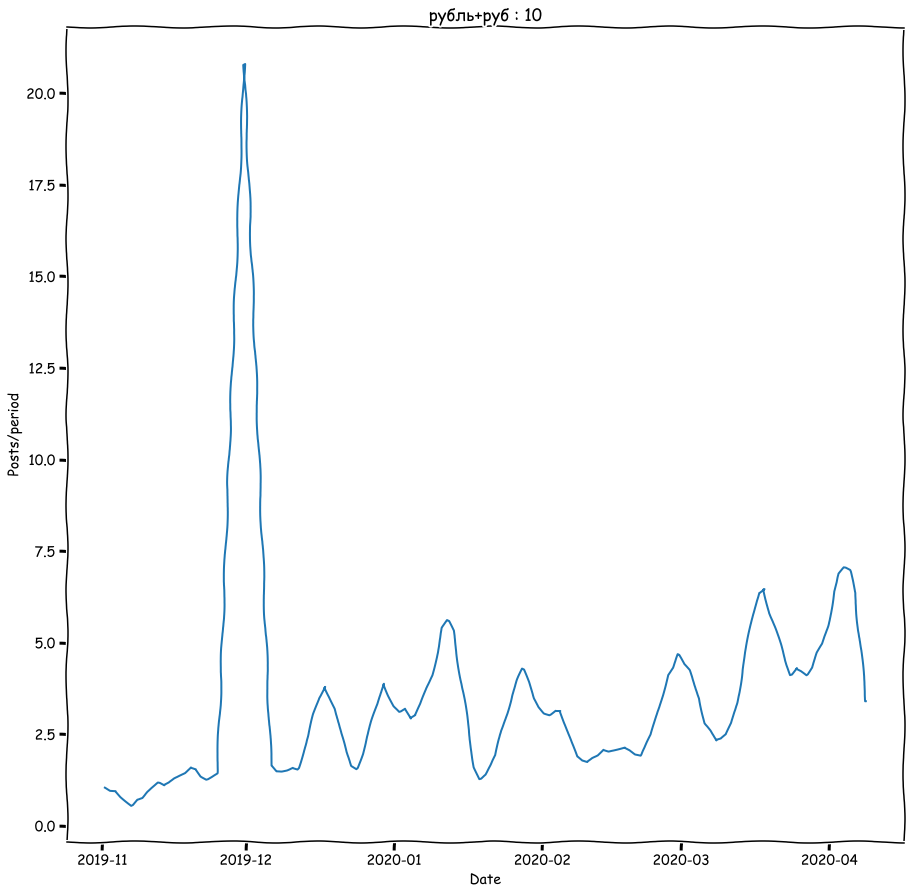

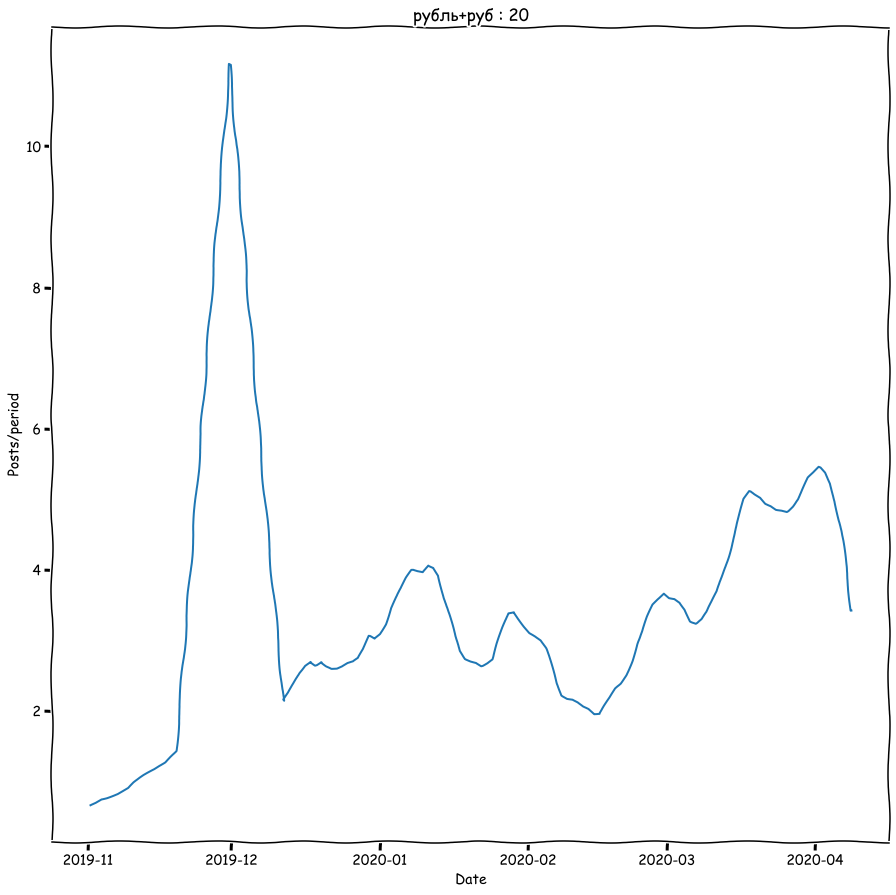

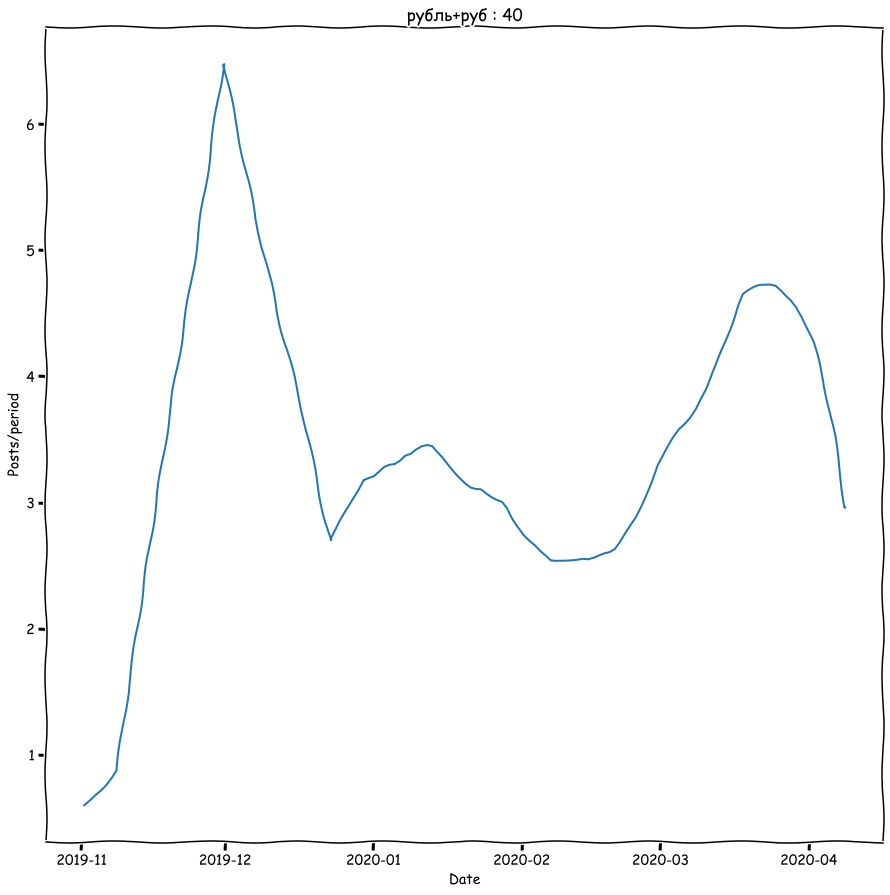

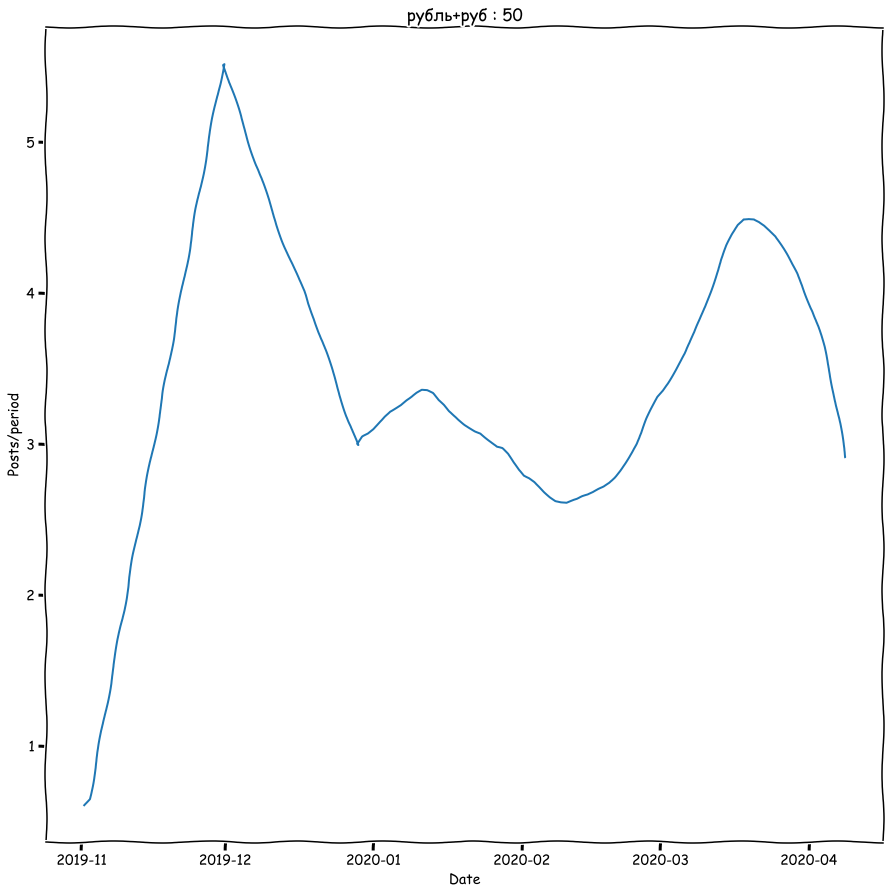

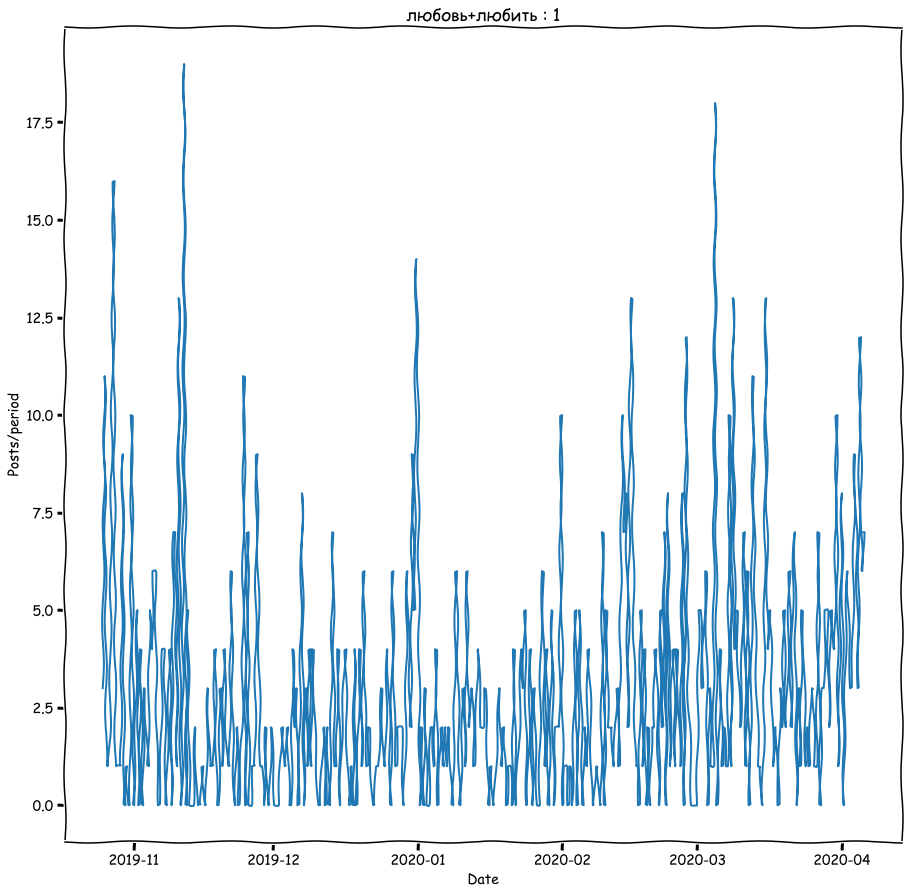

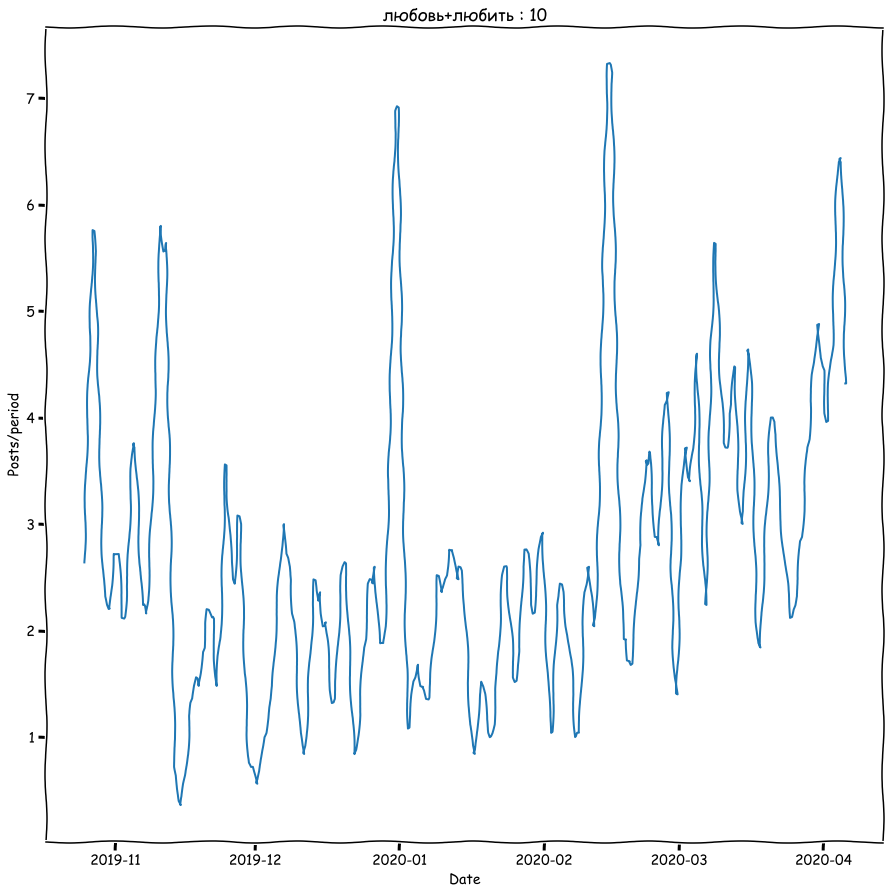

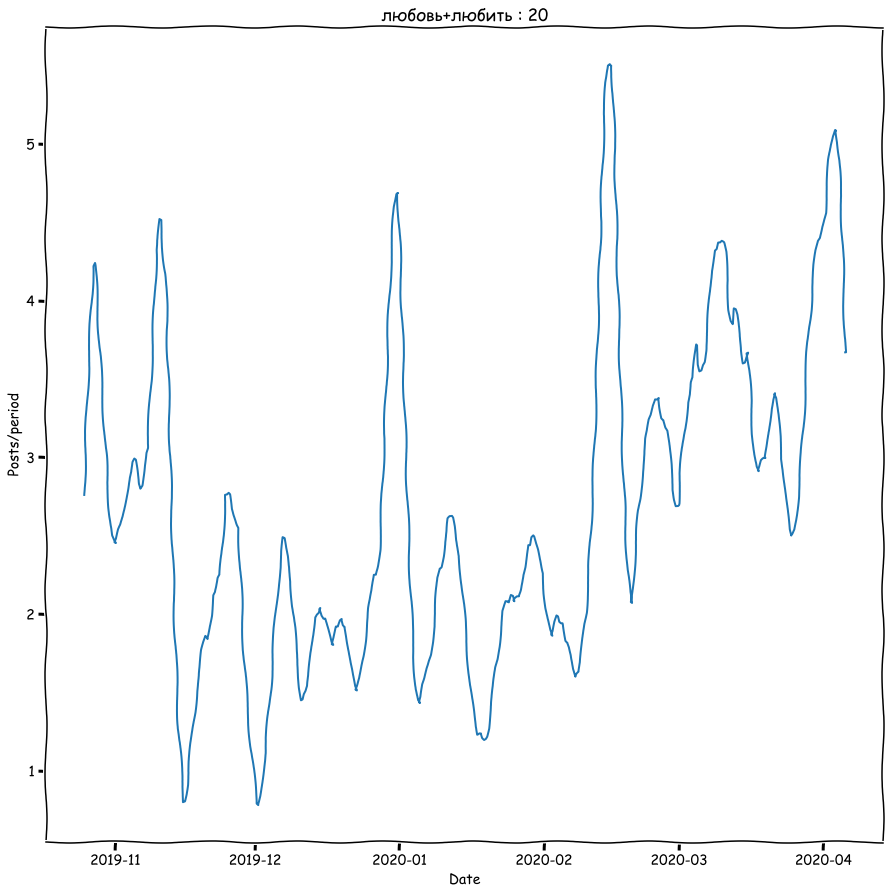

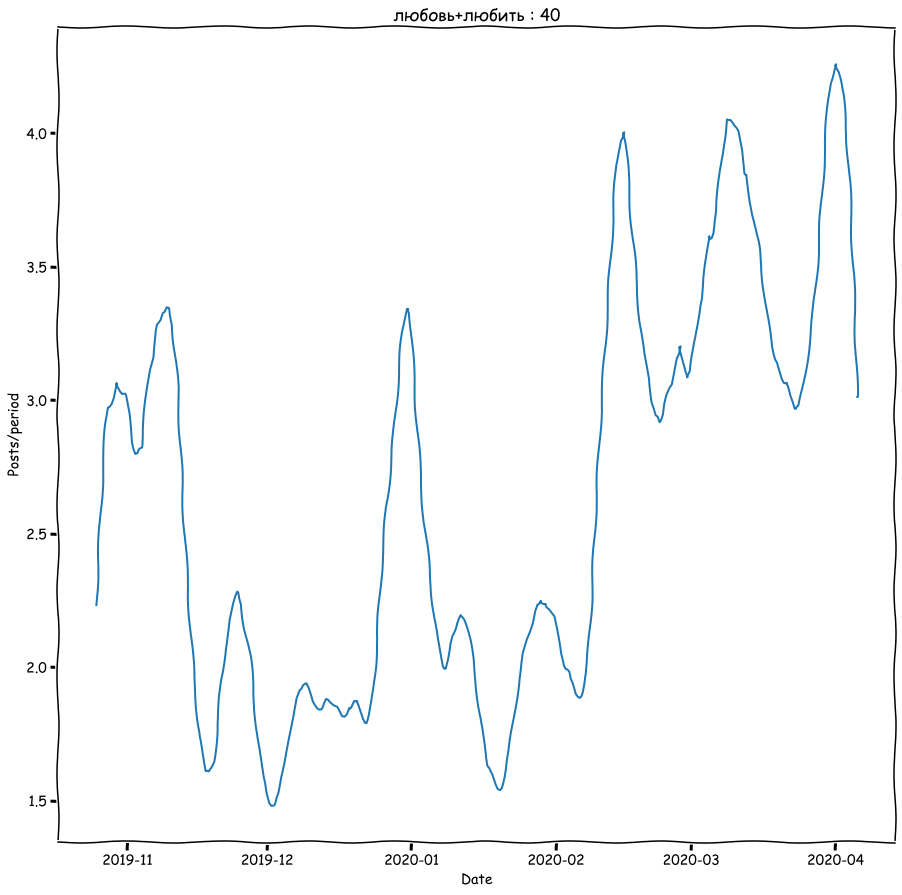

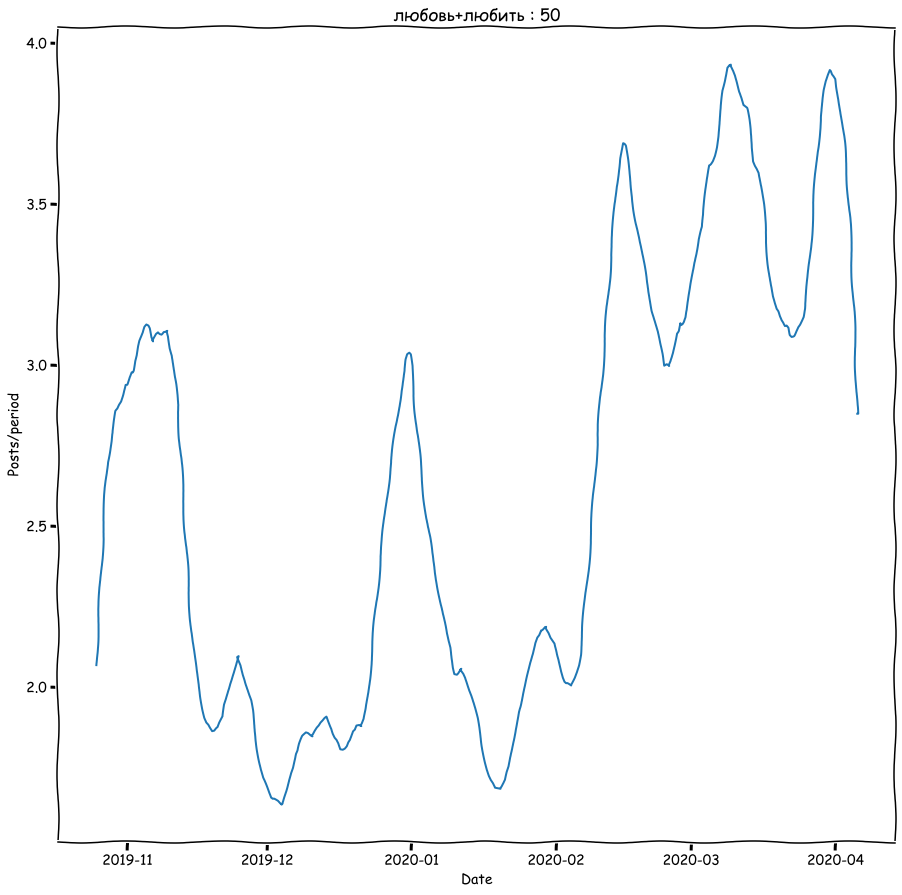

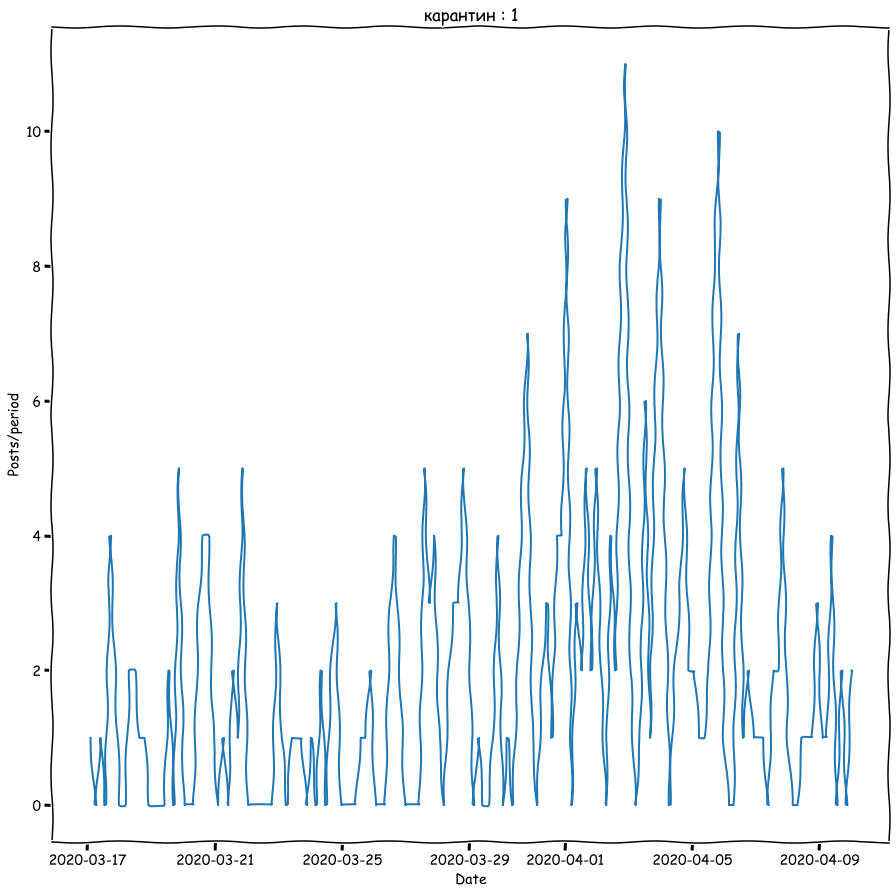

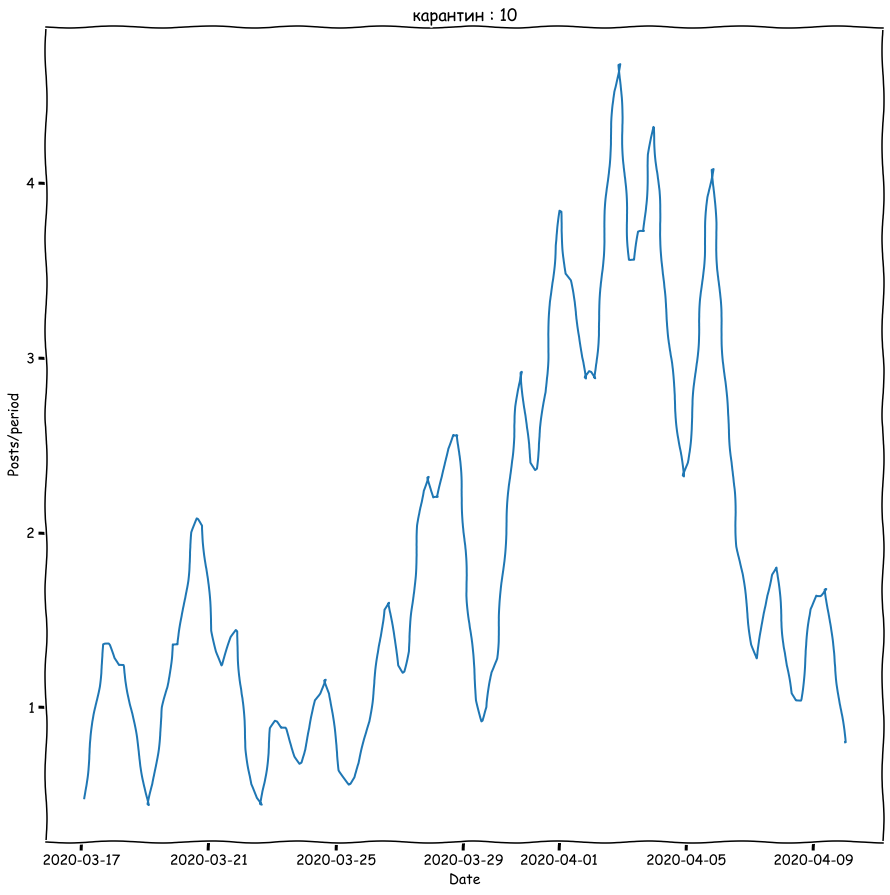

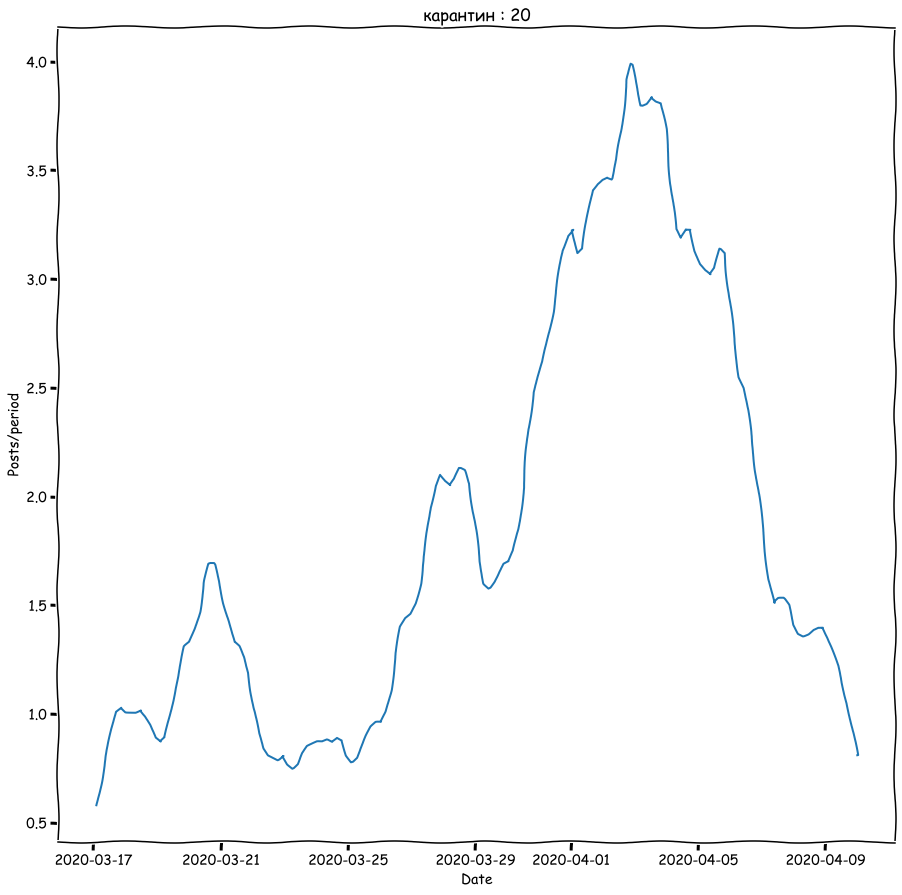

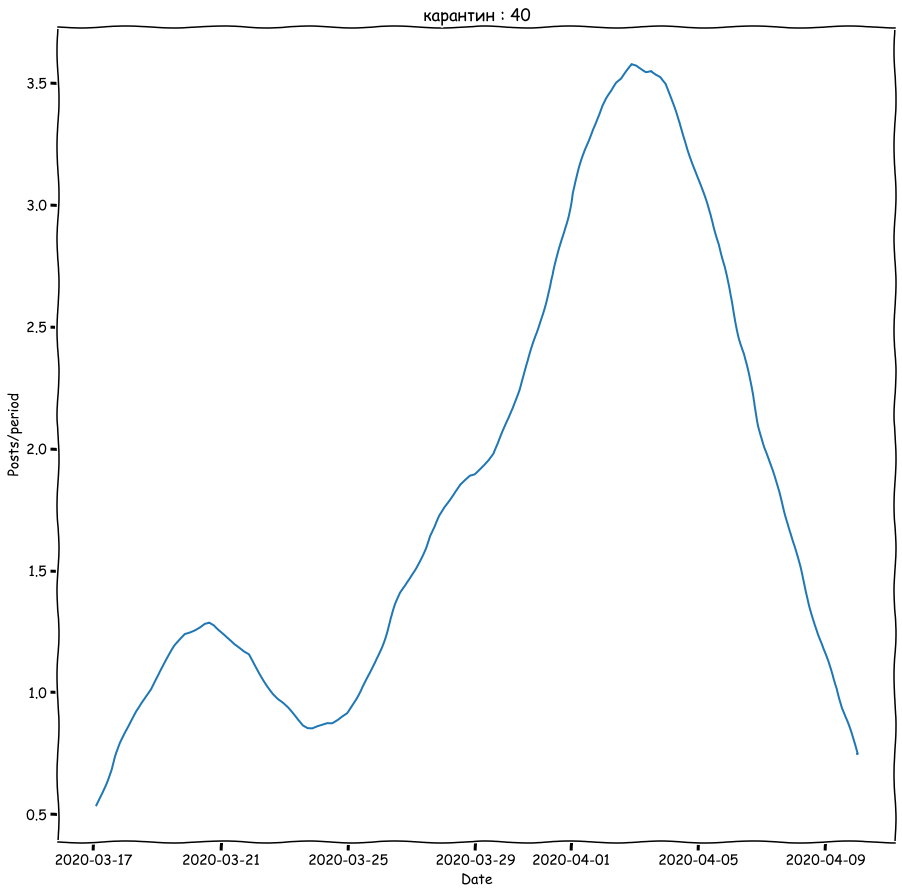

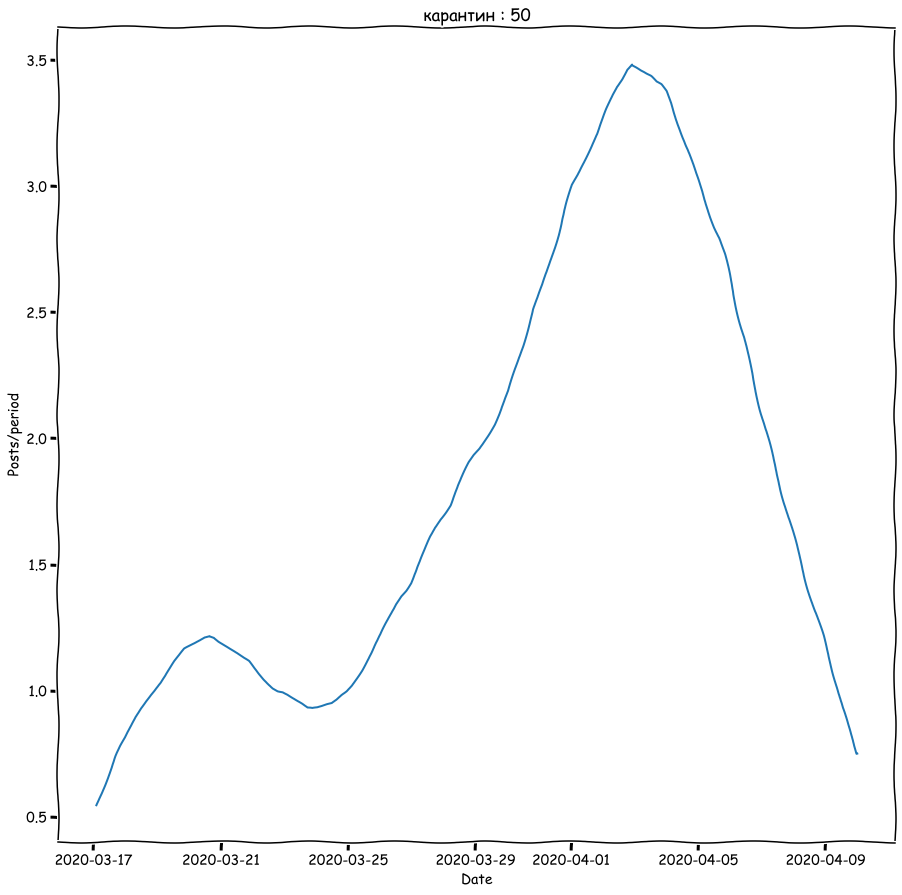

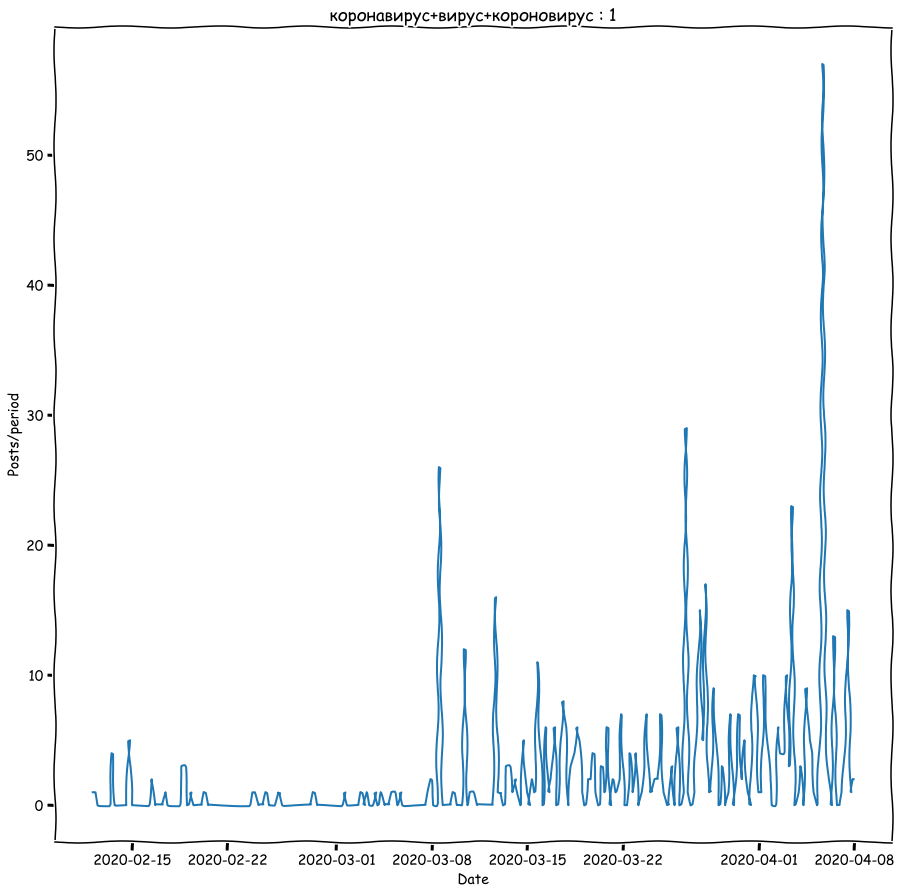

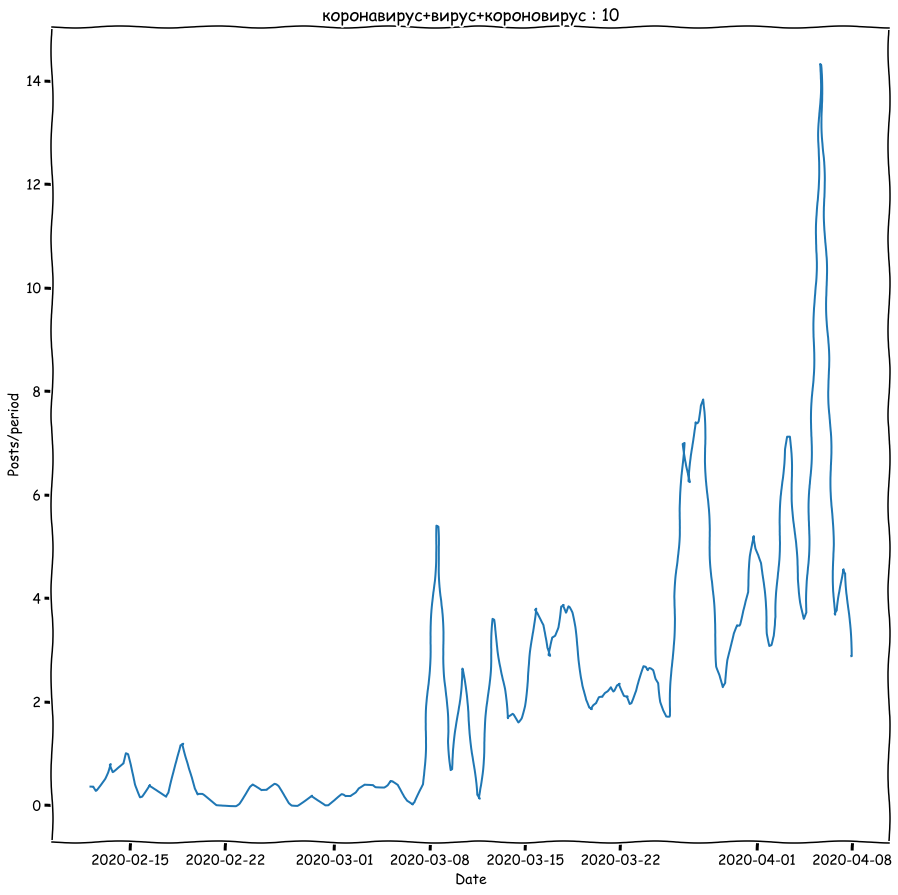

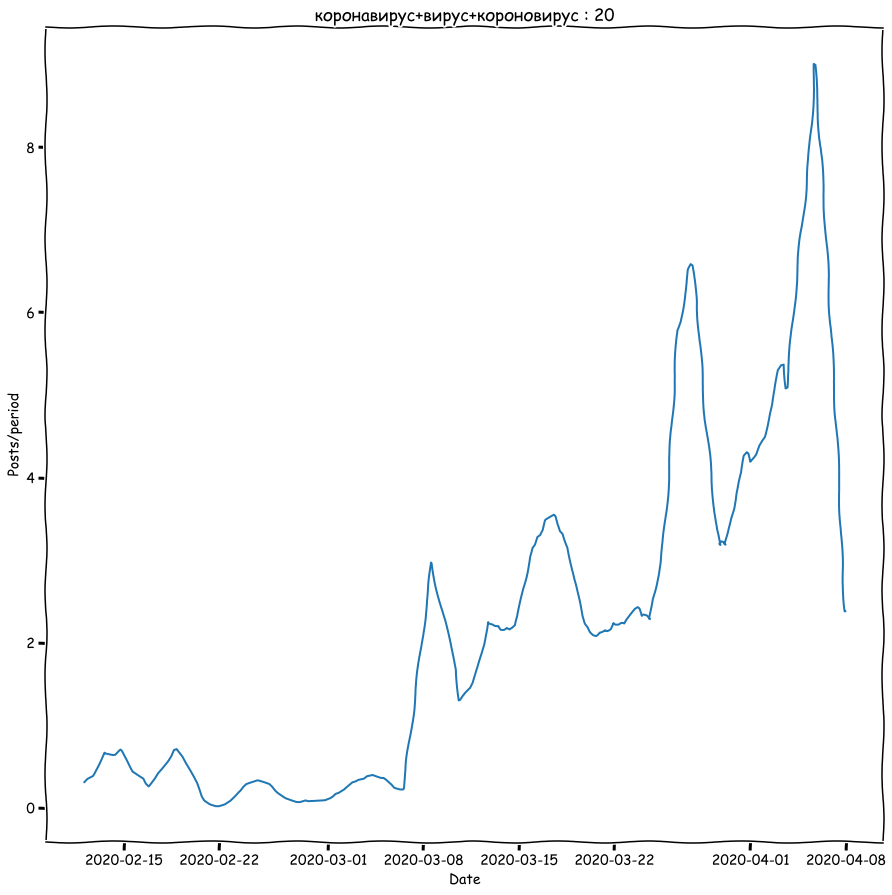

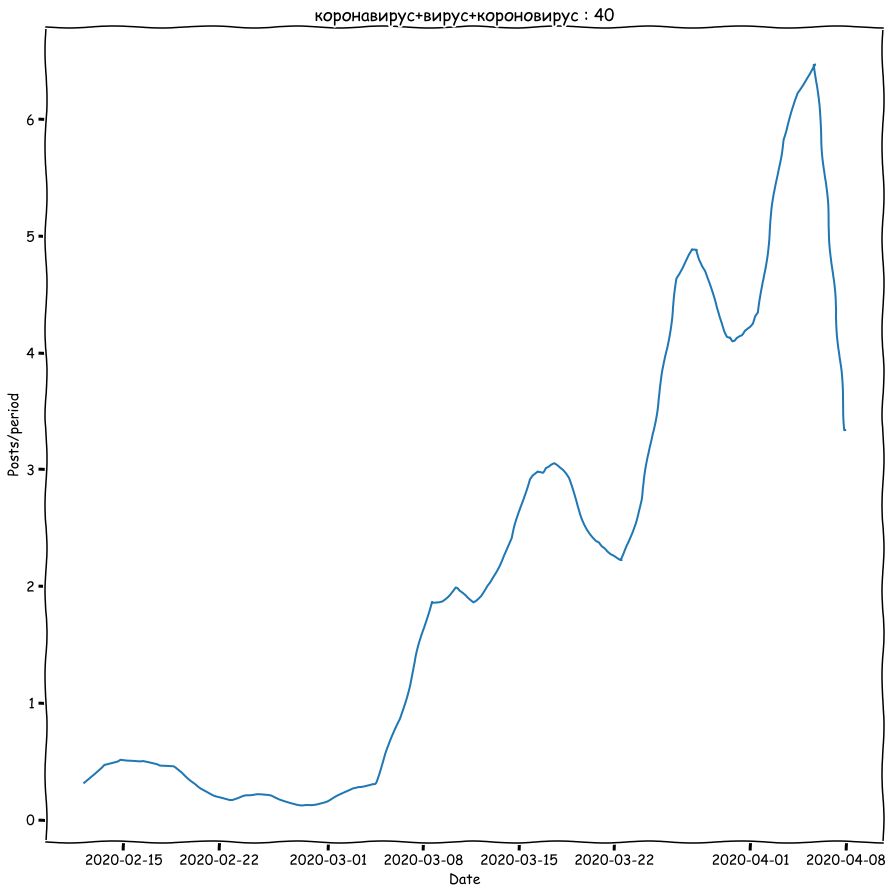

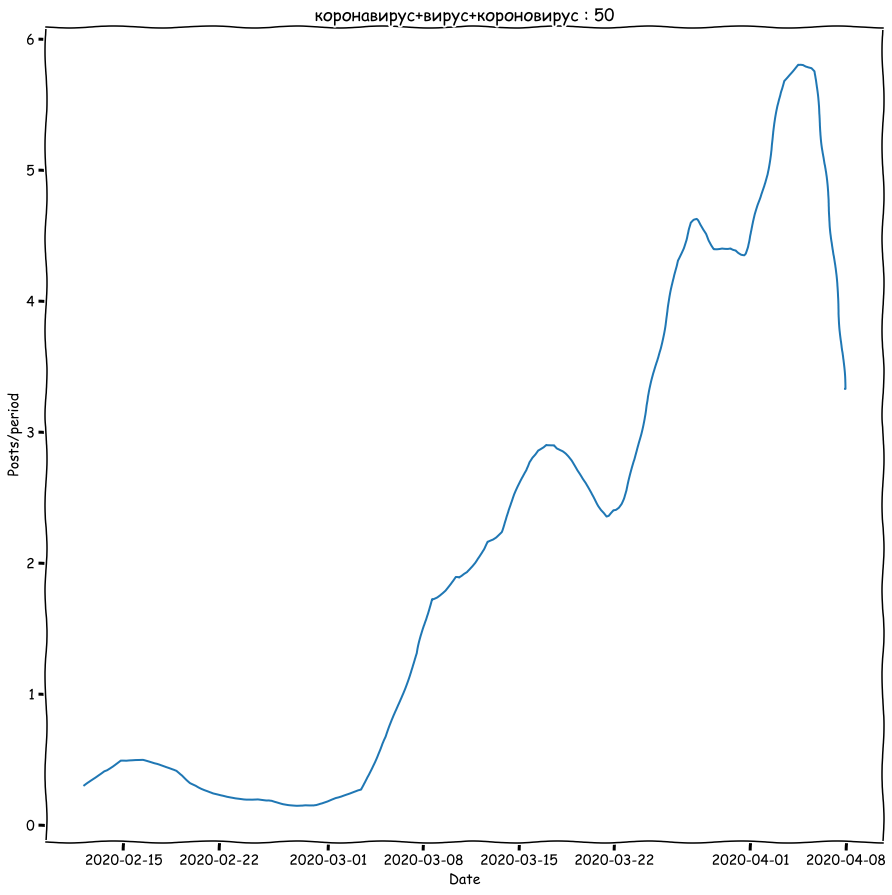

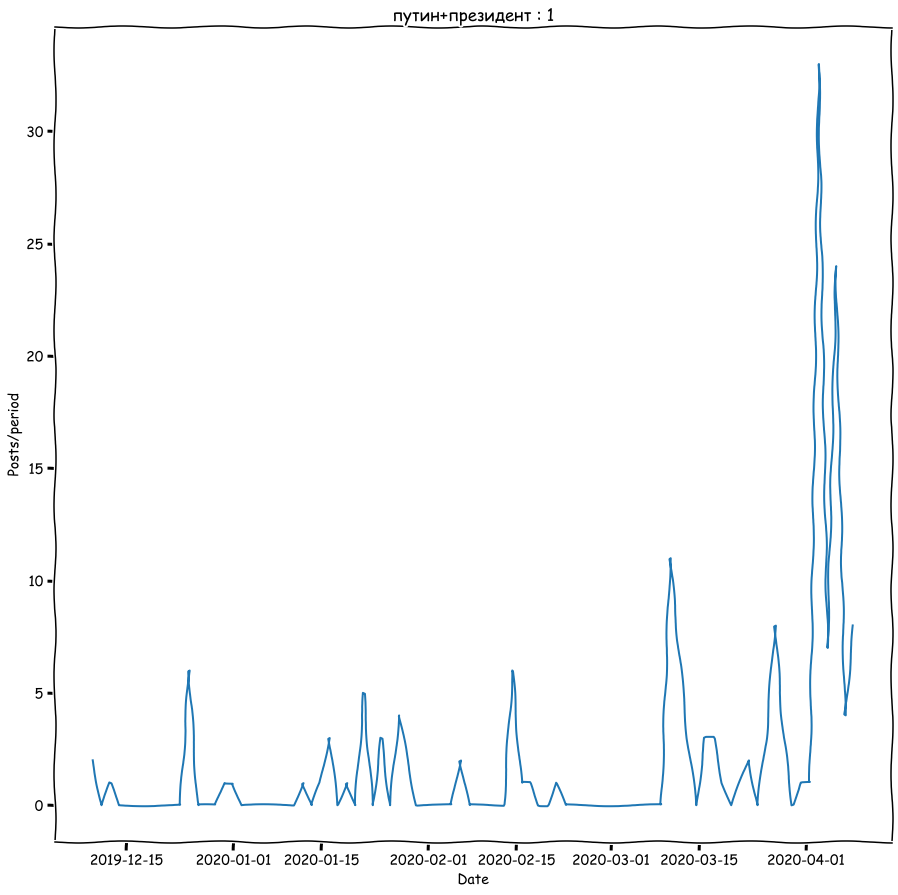

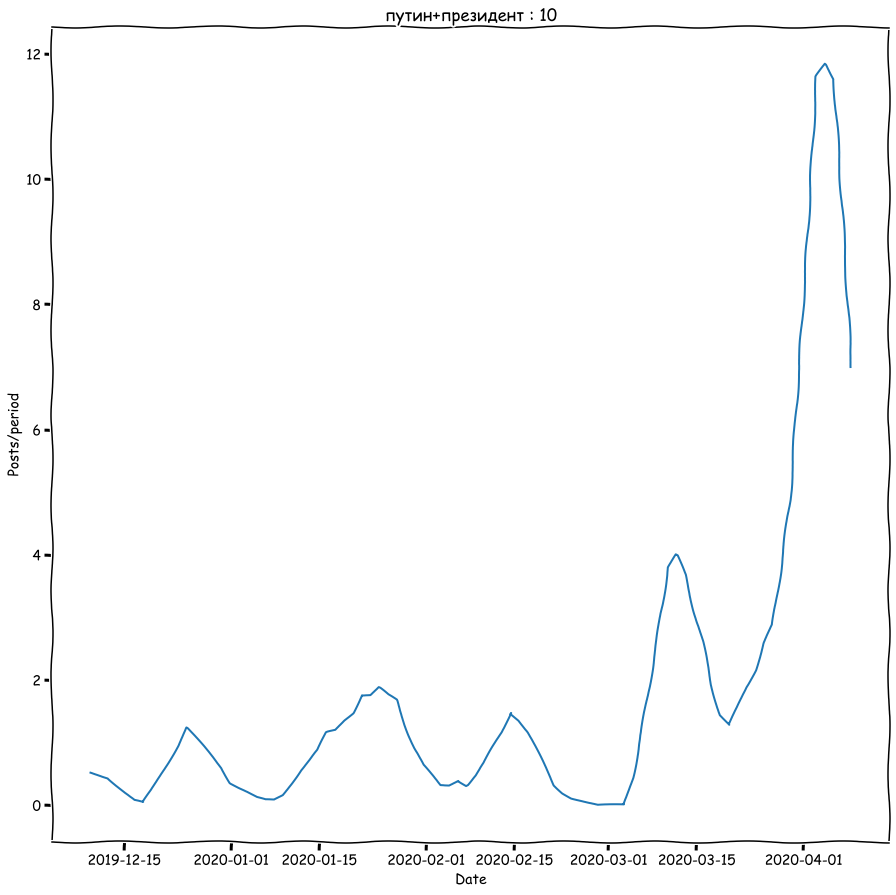

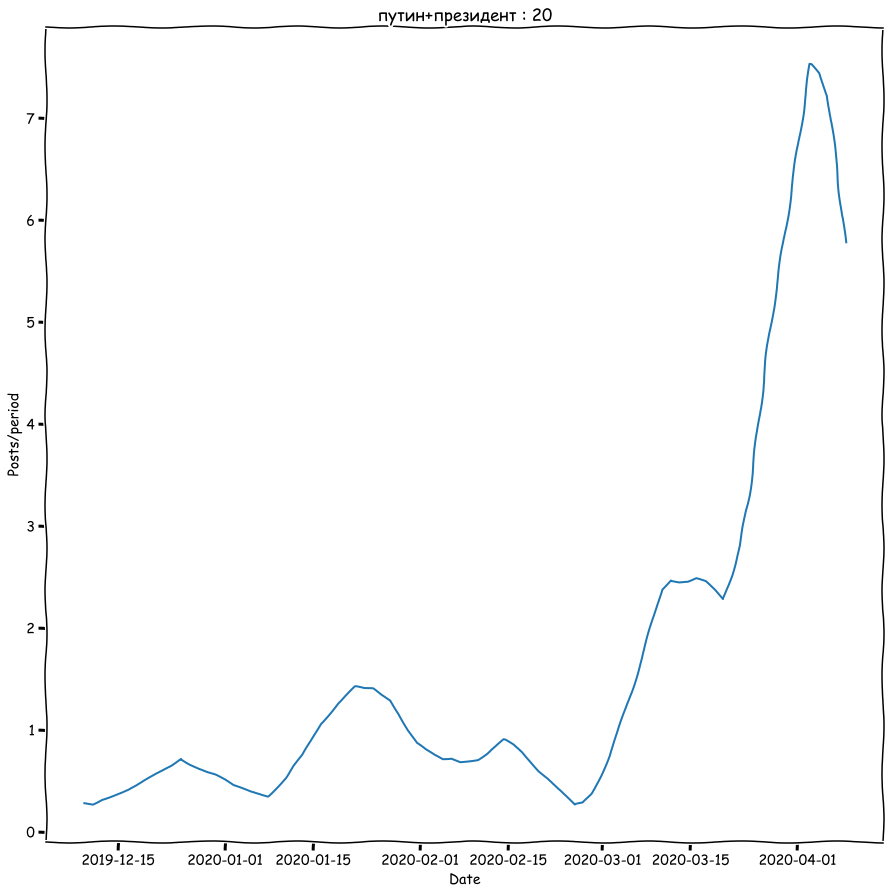

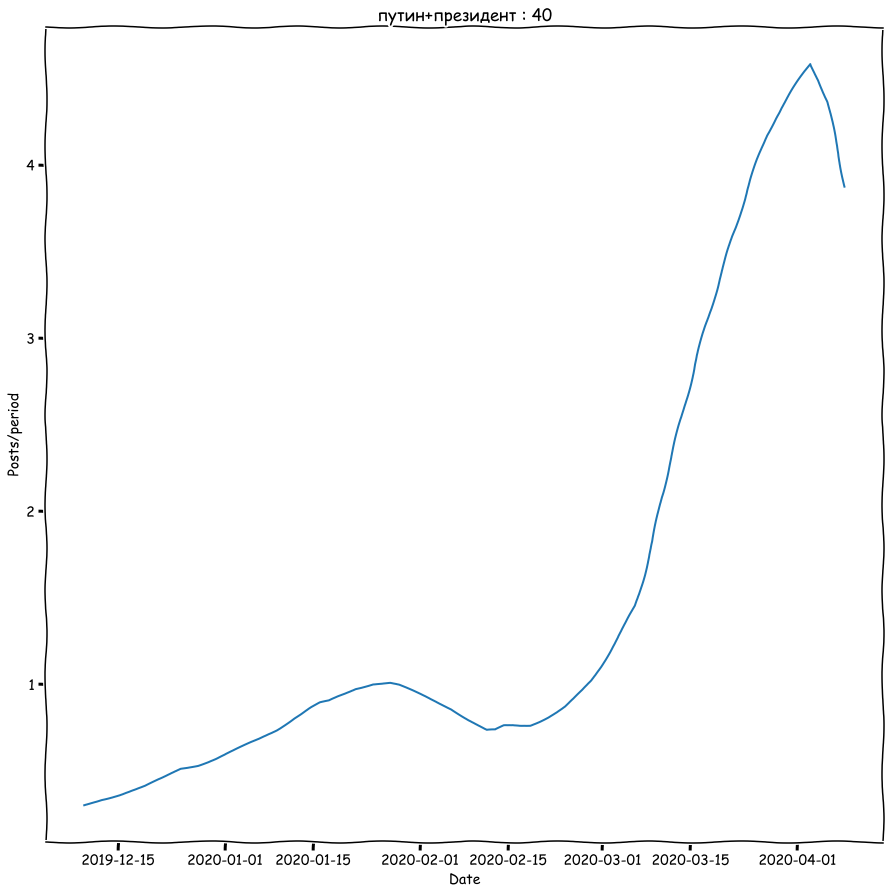

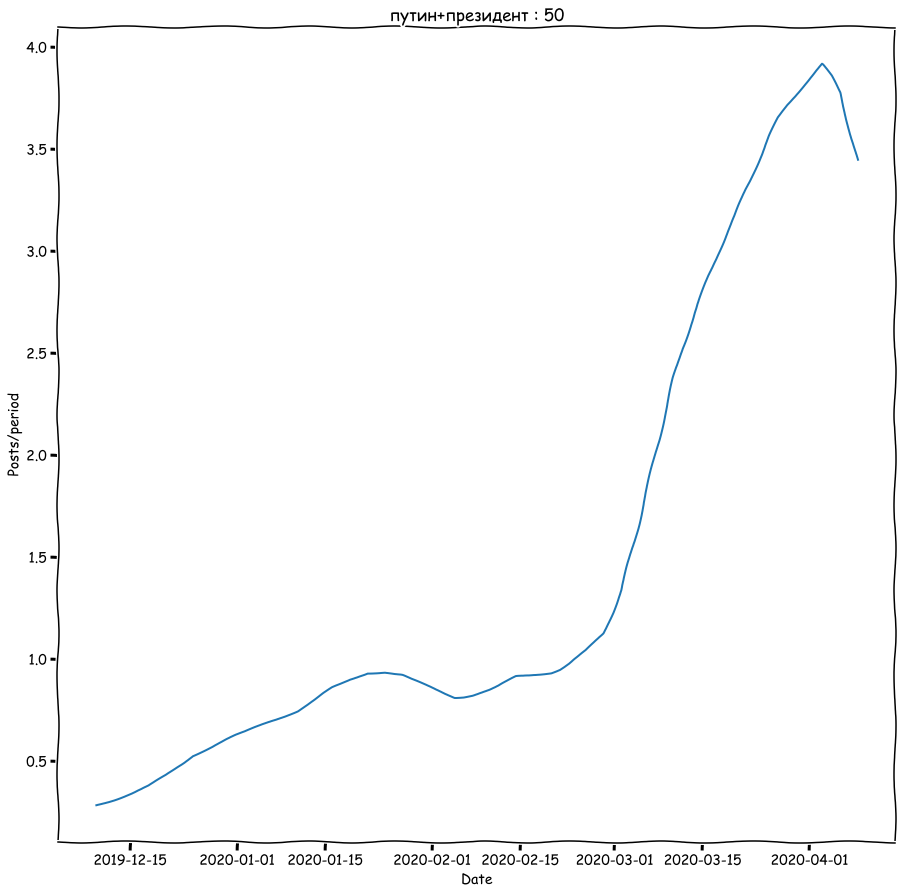

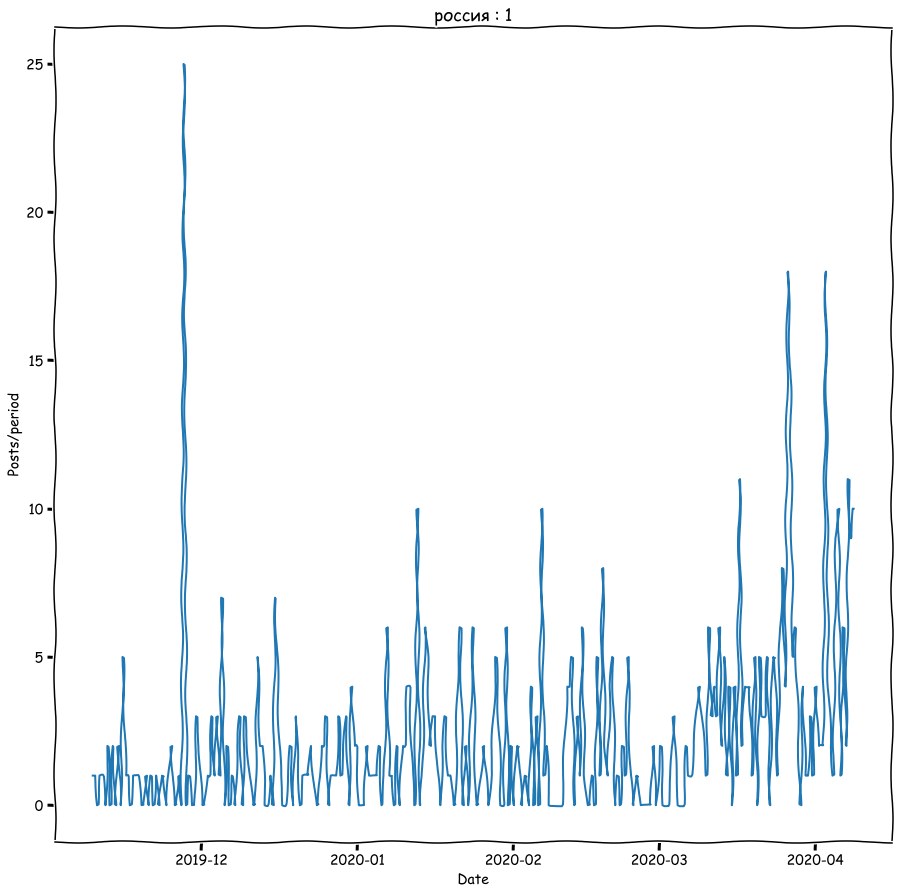

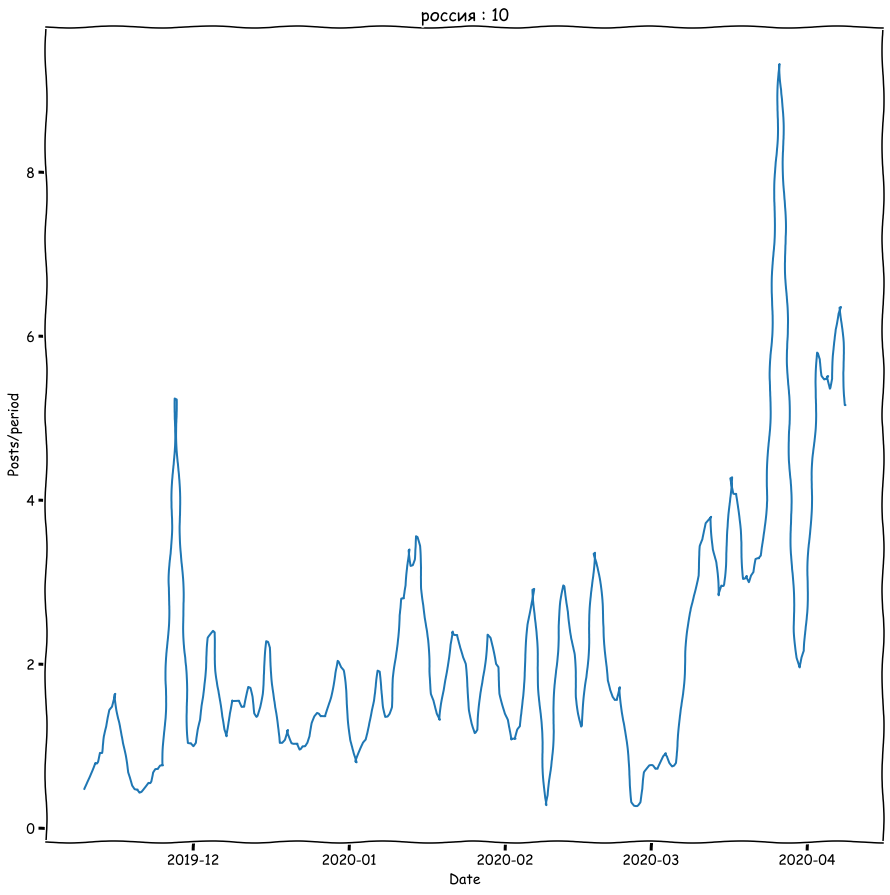

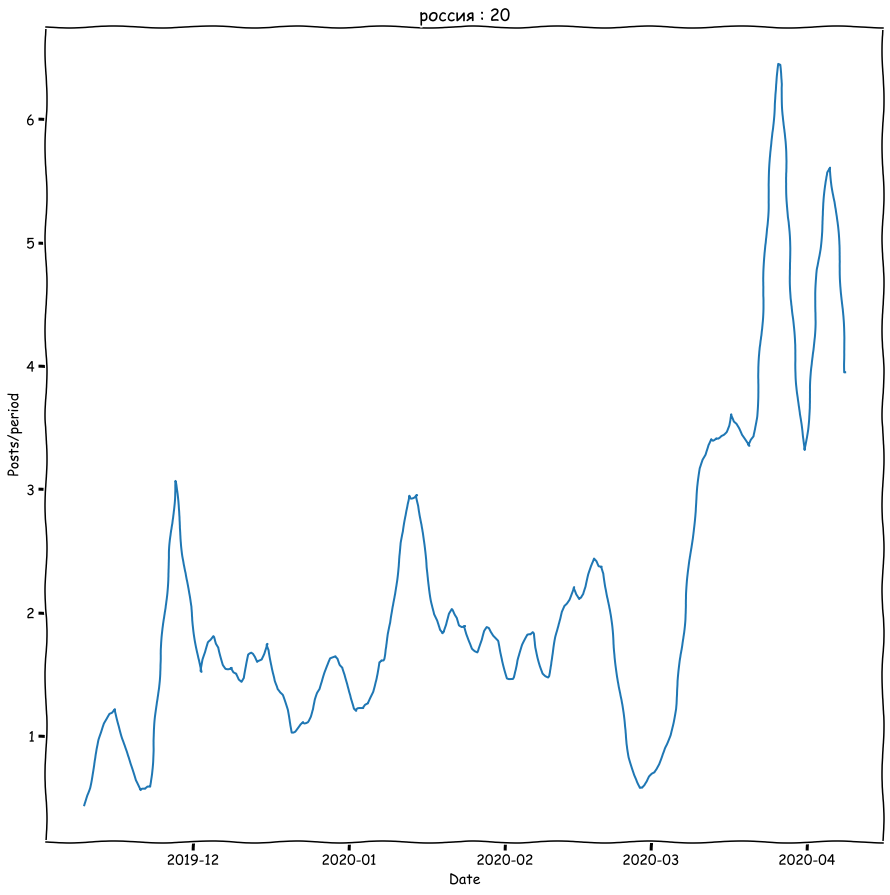

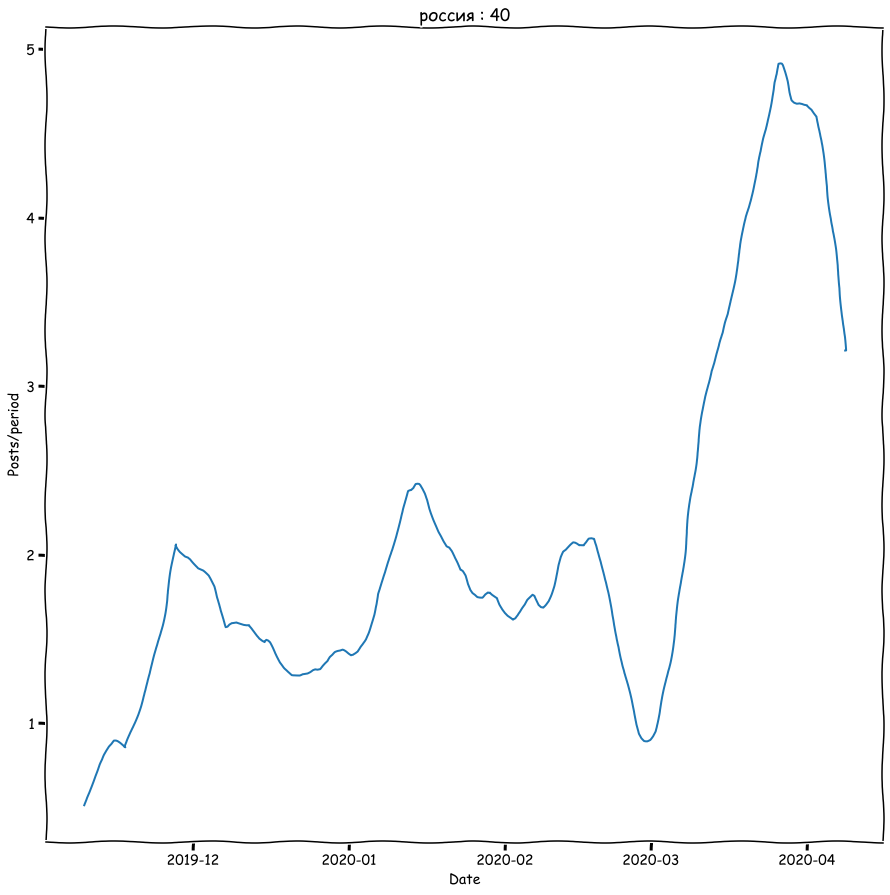

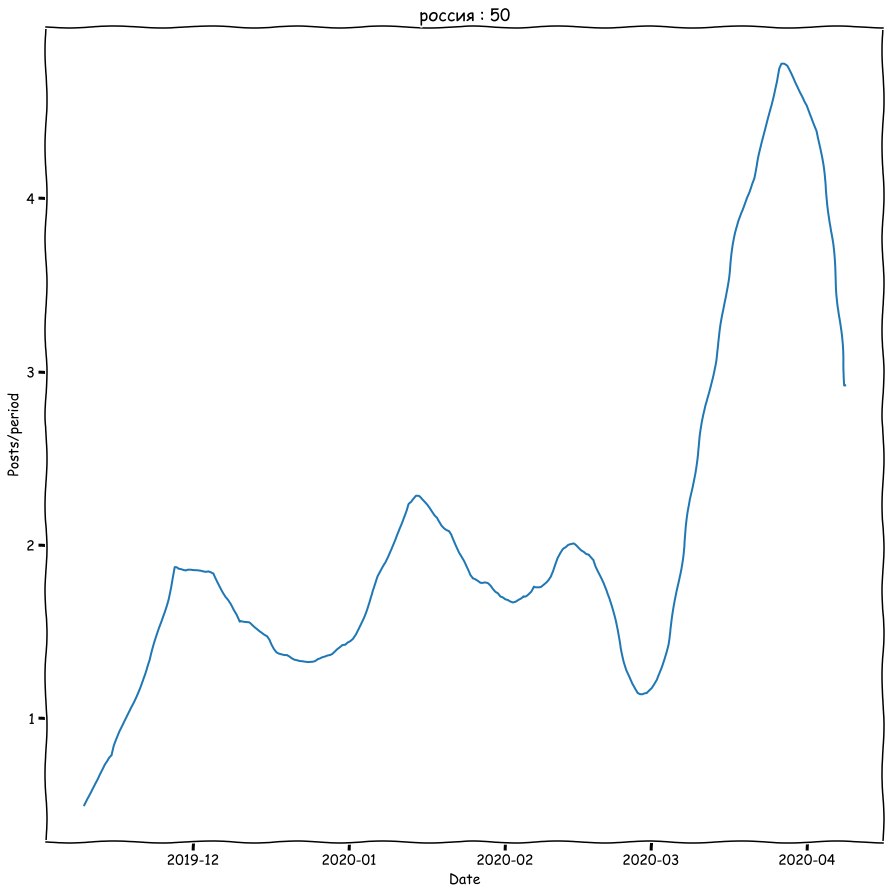

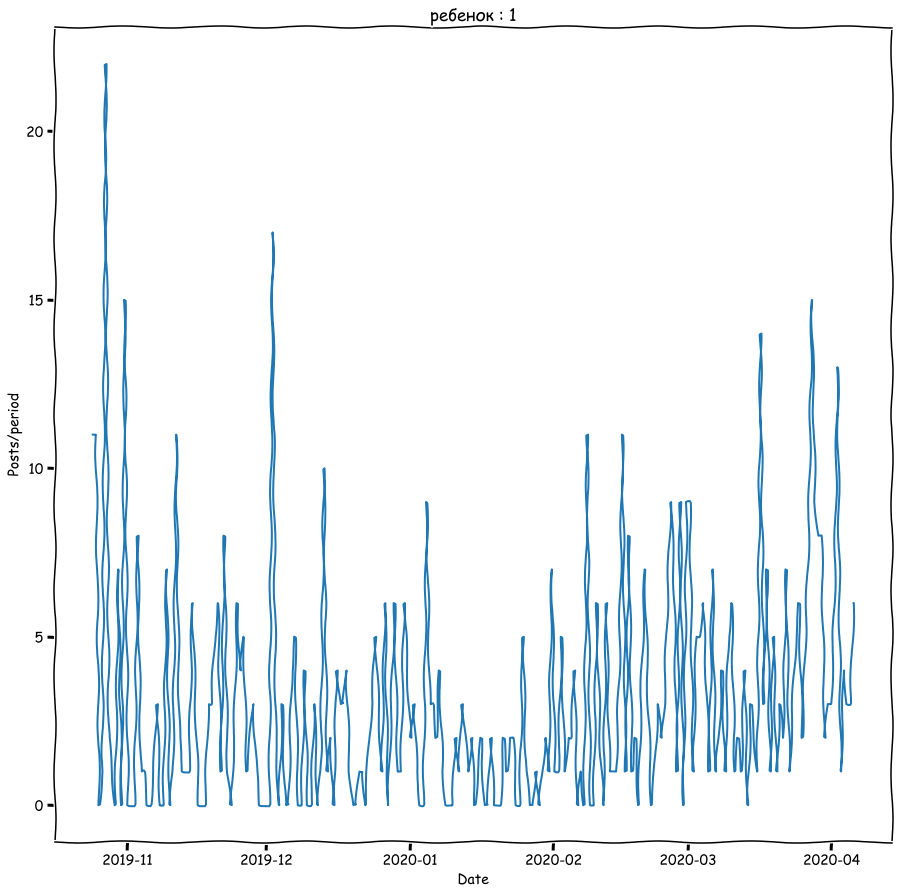

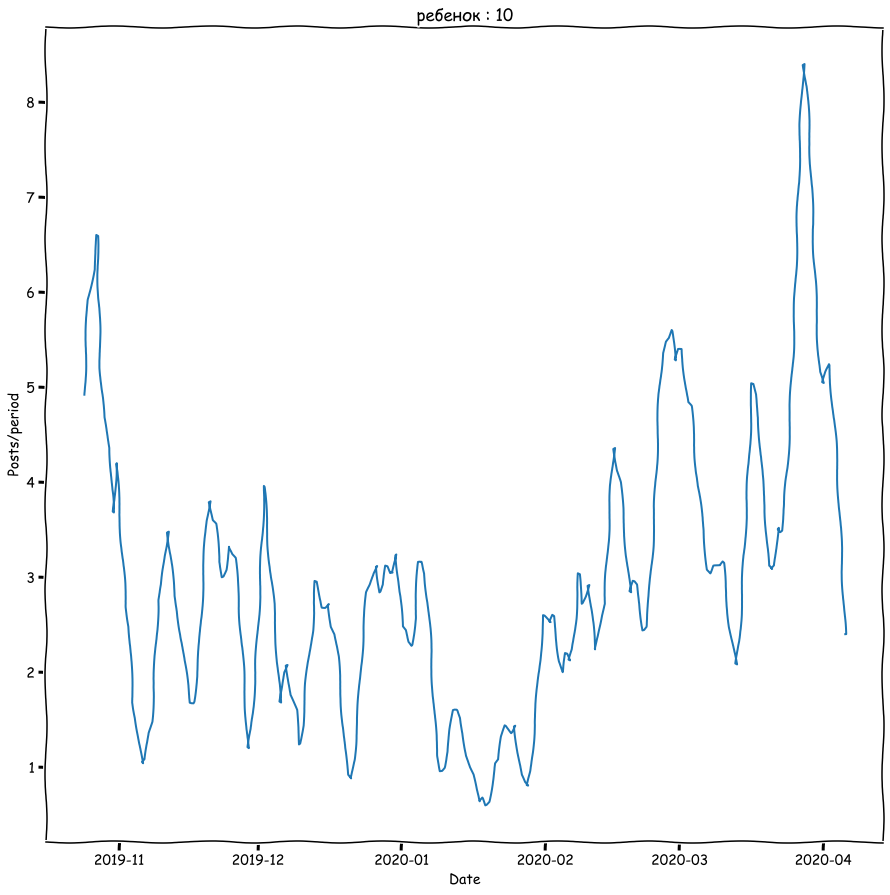

In [8]:

for ks in "новый", "когда", ("сессия", ), ("рубль", "руб"), ("любовь", "любить"), "карантин", \
          ("коронавирус", "вирус", "короновирус"), ("путин", "президент"), ("россия", ), ("ребенок", ):
    if not isinstance(ks, tuple):
        ks = (ks, )
    
    for k in ks:
        if k not in words:
            words[k] = Word(k)
            await words[k].download()
    
    word = words[ks[0]]
    for k in ks[1:]:
        word += words[k]
    
    for periods in (1, 10, 20, 40, 50):
        try:
            with plt.xkcd():
                ax = get_ax(f"{word.word} : {periods}")
                
                plot(ax, word.slice().to_grid(1 / 3).moving_avg(periods=periods), name=word.word)
            
            # plot(ax, word.slice().integrate().diff().moving_avg(periods=12), name="slice+int")
            
                plt.savefig(f'data/pictures/{word.word}_{periods}.png')
                # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
                if periods == 10:
                    plt.show()
        except Exception as e:
            print(word, periods, e)

<ipython-input-146-0f5b4e9fc8db>:4: RuntimeWarning:

divide by zero encountered in true_divide



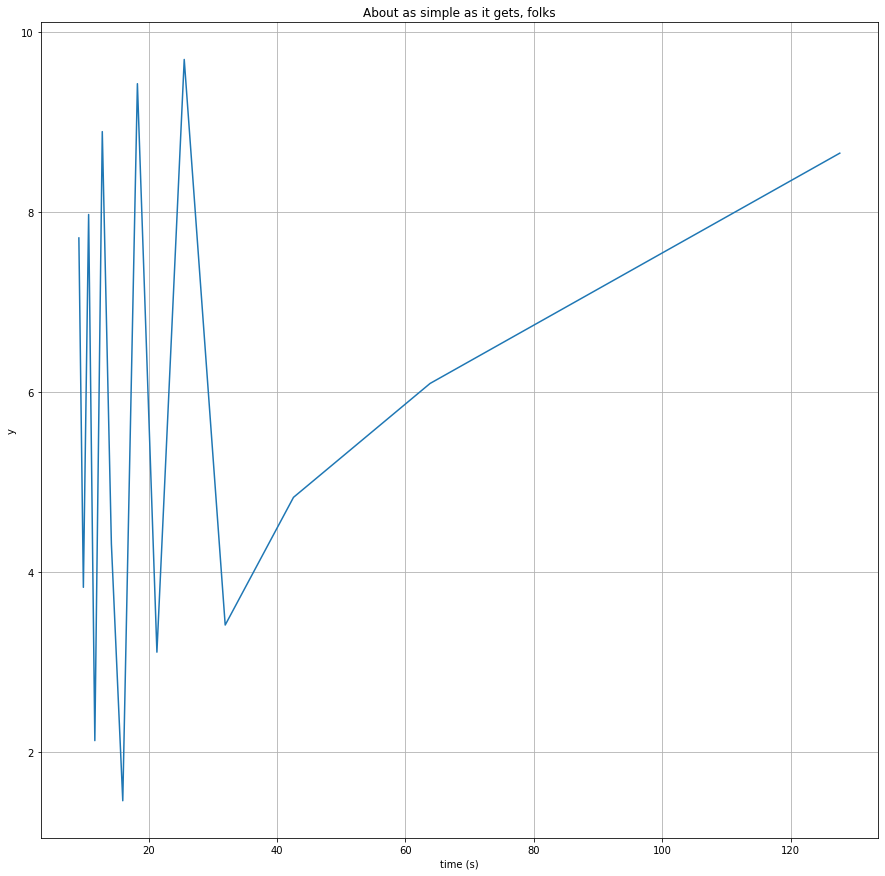

In [146]:
word = words['президент'].slice().to_grid(1).moving_avg(periods=2)
rfft = np.fft.rfft(word.v)

periods = 1 / np.fft.rfftfreq(len(word.v), d=(word.t[1] - word.t[0])) / 60 / 60 / 24
values = np.abs(rfft)

_w = Word("fft", periods[1:], values[1:])

ax = get_ax()

plot(ax, _w, "fsafd")

plt.show()



In [121]:
return
fig = go.Figure()

# for i in range(1, 10):
#     draw_word(fig, word.slice().to_grid(i/2).integrate(), name=f"grid_{i/2}")

draw_word(fig, word.slice().to_grid(0.5).moving_avg(periods=10), name="slice+int")

# for mov in (False,):
#     for i in range(1, 5):
#         draw_word(fig, word.get_smooth(i, mov=mov), name=f'smooth_{i}_{mov}')

fig.show()



SyntaxError: 'return' outside function (<ipython-input-121-36de6cd5c0ff>, line 1)

In [87]:
for k in words:
    print(k)

день
весь
все
мой
год
который
так
свой
человек
такой
очень
рождение
если
кто
мочь
вот
новый
один
себя
или
когда
самый
уже
друг
хороший
только
тот
много
она
жизнь
время
хотеть
можно
просто
чтобы
спасибо
знать
работа
первый
еще
даже
любить
сегодня
раз
нет
каждый
становиться
про
сам
место
другой
сделать
делать
новосибирск
какой
хорошо
ваш
говорить
понимать
без
всегда
тут
давать
большой
город
где
сказать
мир
дело
надо
сейчас
теперь
приходить
ребенок
начинать
после
два
помогать
любовь
чем
писать
смотреть
вопрос
потому
тоже
через
счастие
нужно
твой
что-то
проходить
здесь
думать
получать
красивый
находить
работать
любимый
фото
жить
при
дом
прекрасный
слово
вообще
интересный
пока
оставаться
видеть
нгу
ребята
пусть
его
последний
группа
час
конечно
нужный
любой
потом
утро
ждать
россия
праздник
книга
история
лето
песня
неделя
решать
вечер
ничто
рука
москва
кто-то
хотеться
поэтому
немного
скоро
посмотреть
вид
поздравлять
почему
желать
академгородок
идти
открытка
узнавать
написать
счастливый
крутой

1.0